In [126]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass, field
from typing import Union, Tuple, Iterable, Optional, Any, Type, Callable, Dict
from tqdm import tqdm
from fancy_einsum import einsum
from scipy import special
from itertools import chain


In [127]:
[a for a in mpl.rcParams.keys() if 'size' in a]

['agg.path.chunksize',
 'axes.labelsize',
 'axes.titlesize',
 'boxplot.flierprops.markersize',
 'boxplot.meanprops.markersize',
 'errorbar.capsize',
 'figure.figsize',
 'figure.labelsize',
 'figure.titlesize',
 'font.size',
 'legend.fontsize',
 'legend.title_fontsize',
 'lines.markersize',
 'ps.papersize',
 'xtick.labelsize',
 'xtick.major.size',
 'xtick.minor.size',
 'ytick.labelsize',
 'ytick.major.size',
 'ytick.minor.size']

In [128]:
mpl.style.use('seaborn-v0_8')
# mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['font.size'] = 20


In [129]:
class Disease:
    def __init__(self, beta: float, gamma: float, delta: float):
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.doubling_time, self.growth_rate, self.decay_rate = self.effective_growth_rate()

    def effective_growth_rate(self):
        '''
        Returns the effective growth rate for the epidemic in the exponential phase
        '''
        b = self.beta
        g = self.gamma
        d = self.delta
        growth_rate = 0.5 * (np.sqrt((d-g)**2 +4*d*b) - d - g)
        doubling_time = np.log(2)/growth_rate
        decay_rate = -0.5 * (d + g + np.sqrt((d-g)**2 +4*d*b))
        return doubling_time, growth_rate, decay_rate
    
    def __str__(self):
        return str(vars(self))

In [130]:
covid = Disease(0.6,1/6,1/5.5)
measles = Disease(2,1/10,1/8)

In [131]:
def find_first_index(condition, axis = -1):
    """
    Finds the index of the first time a condition is met for each row in a 2D numpy array.

    Args:
        array: A 2D numpy array with n rows and m columns.
        condition: A boolean condition to be checked element-wise.

    Returns:
        A 1D numpy array containing the index of the first time the condition is met for each row in the input array.
        Returns -1 if the condition is never met in a row.
    """
    assert isinstance(condition, np.ndarray), "array must be a numpy array"
    assert len(condition.shape) == 2, "array must be a 2D numpy array"
    assert condition.shape[1] > 0, "array must have at least one column"

    # Apply the condition element-wise to the input array and get the index of the first True value along axis 1
    idx = np.argmax(condition, axis=axis)
    
    # If the condition is never met in a row, set the corresponding index to -1
    idx[np.all(~condition, axis=axis)] = -1
    
    return idx

def homogeneous_LR_matrix(n_groups: int, LR: float):
    out = np.identity(n_groups,np.float64)
    out[out == 0] = LR
    return out

def day_to_sim_step(day, delta_t):
    #day should start at zero
    steps_in_day = int(1/delta_t)
    return np.round(steps_in_day * (day + 0.5)).astype(int)

def sim_step_to_day(sim_step, delta_t):
    return np.floor(sim_step * delta_t).astype(int)

def quartiles(data: np.ndarray, axis: int = -1, squeeze = True):
    'returns lower_quartile, median, upper_quartile'
    return tuple(np.quantile(data, [0.25,0.5,0.75],axis=axis).squeeze())

def list_to_str(l: Iterable, sep: str = ''):
    out = ''
    for i in l:
        out+= str(i) + sep
    return out[:-len(sep)]

def dict_to_str(d: dict, sep: str = ', '):
    out = ''
    for key, val in d.items():
        assert isinstance(val, list) or isinstance(val, str)
        val_str = list_to_str(val,sep) if isinstance(val, list) else val
        out += f'{key}: {val_str}{sep}'
    return out[:-len(sep)]

def force_iterable(input):
    return input if isinstance(input, Iterable) else [input]

def force_list(input):
    return list(input) if isinstance(input, Iterable) and not isinstance(input,str) else [input]

def show_fig(fig, figsavename):
    if figsavename is not None:
        fig.savefig(figsavename)

def total_daily(array: np.ndarray, delta_t: float, axis: int = -1):
    #the timeseries axis must be the last axis!
    assert axis == -1, 'the timeseries axis must be the last axis!'
    window = int(1/delta_t)
    shape = array.shape
    assert (len(shape) == 2) or (len(shape) == 1)
    assert shape[-1] % window == 0
    return array.reshape(shape[:-1] + (shape[-1]//window,window)).sum(axis=-1)

def mean_daily(array: np.ndarray, delta_t: float, axis: int = -1):
    #the timeseries axis must be the last axis!
    assert axis == -1, 'the timeseries axis must be the last axis!'
    window = int(1/delta_t)
    shape = array.shape
    assert (len(shape) == 2) or (len(shape) == 1)
    assert shape[-1] % window == 0
    return array.reshape(shape[:-1] + (shape[-1]//window,window)).mean(axis=-1)
     

In [132]:
class City:
    def __init__(self,
                 N0s: np.ndarray,
                 groups: list[Union[str,int]],
                 compartments: str = 'SEIR',
                 mixing_LR: Optional[np.ndarray] = None):
        """
        Initializes the City object.

        Args:
        - N0s (np.ndarray): An array of initial population sizes for each group.
        - groups (list): A list representing the groups in the model.
        - compartments (str): A string representing the compartment model used in the model. Currently only 'SEIR' is supported.
        - mixing_LR (np.ndarray): An optional array representing the matrix of mixing likelihood ratios for groups i and j. All diagonal elements should be one.

        Returns:
        - None
        """
        self.n_groups = len(groups)
        self.groups = groups

        # Check that the length of N0s matches the number of groups
        assert len(N0s) == self.n_groups, "N0s should have length n_groups"

        self.N0s = N0s
        self.N0 = self.N0s.sum()

        assert compartments == 'SEIR', "Only SEIR compartment model supported at the moment"
        self.model_type = compartments
        self.compartments = [l for l in compartments]

        # Check and set the mixing_LR matrix
        if mixing_LR is None:
            mixing_LR = np.identity(self.n_groups)
        assert mixing_LR.shape == (self.n_groups, self.n_groups)
        assert np.all(mixing_LR.diagonal() == 1)
        assert np.all(mixing_LR == mixing_LR.T)
        self.mixing_LR = mixing_LR

        # Set the indices of the compartments
        self.S_index = self.compartments.index('S')
        self.E_index = self.compartments.index('E')
        self.I_index = self.compartments.index('I')
        self.R_index = self.compartments.index('R')

        self.name: Optional[Union[int,str]] = None
        self.disease: Optional[Disease] = None

        self.data_cols = {'municipal': 'blue', 'arrivals': 'red', 'departures': 'green'}
        self.error_bar_cols = {'municipal': 'cornflowerblue', 'arrivals': 'lightcoral', 'departures': 'mediumaquamarine'}

    def reset_parameters(self, I0: int = 0, n_sims: int = 1, simulation_steps: int = 100):
        """
        Sets self.municipal to an array of zeros of size (n_groups, n_compartments, n_sims, timesteps) for each compartment in the city
        The only values which aren't zero are the initial value of I which is I0 and the initial value of S which is N-I0
        The default value of I0 is the value set in the class initialization, but can be overridden
        """
        # if I0 is None:
        #     I0 = self.I0
        self.I0 = I0
        self.municipal = np.zeros((self.n_groups,len(self.compartments),self.n_sims, self.simulation_steps),dtype = np.int64)
        self.arrivals = np.zeros((self.n_groups,len(self.compartments),self.n_sims, self.simulation_steps),dtype = np.int64)
        self.departures = np.zeros((self.n_groups,len(self.compartments),self.n_sims, self.simulation_steps),dtype = np.int64)
        self.community_infections = np.zeros((self.n_groups, self.n_sims, self.simulation_steps), dtype=np.int64)
        self.initial_conditions()
    
    def initial_conditions(self):
        raise ModuleNotFoundError
    
    def multiple_sims(self, delta_t: float, epidemic_time: Union[int,float], disease: Disease, I0: int = 0, n_sims: int = 100):
        assert (1 / delta_t) % 1 == 0, "1/delta_t must be an integer"
        self.n_sims = n_sims
        self.delta_t = delta_t
        self.epidemic_time = epidemic_time
        p_recovery = 1 - np.exp( - delta_t * disease.gamma)
        p_infectious = 1 - np.exp( - delta_t * disease.delta)
        self.simulation_steps = int(epidemic_time // delta_t) + 1
        self.times: np.ndarray = np.linspace(0, epidemic_time, self.simulation_steps)
        self.scaled_times: np.ndarray = self.times /disease.doubling_time
        self.reset_parameters(I0, n_sims, self.simulation_steps)
        for sim_step in tqdm(range(1,self.simulation_steps)):
            self.step_internal(disease.beta,
                      delta_t,
                      p_infectious,
                      p_recovery,
                      sim_step)
        self.daily_flight_data(moving_average)
    
    def __call__(self,
                 delta_t: float,
                 epidemic_time: Union[int,float],
                 disease: Disease,
                 I0: int = 0,
                 n_sims: int = 100):
        return self.multiple_sims(delta_t, epidemic_time, disease, I0, n_sims)

    def step_internal(self,
                      beta:float,
                      delta_t: float,
                      p_infectious: float,
                      p_recovery: float,
                      simulation_step: int):
        N = self.municipal[...,simulation_step-1].sum(axis = 1)
        
        S = self.municipal[:,self.S_index,:,simulation_step-1]
        E = self.municipal[:,self.E_index,:,simulation_step-1]
        I = self.municipal[:,self.I_index,:,simulation_step-1]
        R = self.municipal[:,self.R_index,:,simulation_step-1]


        modified_I = einsum('group1 group2, group2 n_sims -> group1 n_sims', self.mixing_LR, I)
        modified_N = einsum('group1 group2, group2 n_sims -> group1 n_sims', self.mixing_LR, N)
        exposure_rate = beta * modified_I/modified_N
        p_exposure = 1 - np.exp(- delta_t * exposure_rate)
        n_exposed = np.random.binomial(S, p_exposure)
        n_infectious = np.random.binomial(E,p_infectious)
        n_recovered = np.random.binomial(I,p_recovery)

        self.municipal[:,self.S_index,:,simulation_step] = S - n_exposed
        self.municipal[:,self.E_index,:,simulation_step] = E + n_exposed - n_infectious
        self.municipal[:,self.I_index,:,simulation_step] = I + n_infectious - n_recovered
        self.municipal[:,self.R_index,:,simulation_step] = R + n_recovered
        self.community_infections[..., simulation_step] = self.community_infections[..., simulation_step-1] + n_exposed

    def daily_flight_data(self, moving_avg = True):
        window = int(1/self.delta_t)
        
        if moving_avg:
            kernel = np.zeros(2*self.simulation_steps-1)
            kernel[self.simulation_steps-1:self.simulation_steps+window-1] = 1
            strided_kernel = np.flip(np.lib.stride_tricks.sliding_window_view(kernel, self.simulation_steps).astype(int).copy(),axis=0)
            outputs = [np.zeros_like(self.arrivals)] * 2
            for i,data in tqdm(enumerate([self.arrivals, self.departures])):
                output = einsum('groups compartments sims simsteps, kernelsteps simsteps -> groups compartments sims kernelsteps', data, strided_kernel)
                # if i == 0:
                #     print('data', data)
                #     print('kernel', strided_kernel)
                #     print('output', output)
                outputs[i] = output
            self.arrivals_moving_avg, self.departures_moving_avg = outputs[0], outputs[1]
            
        self.arrivals_daily_avg = self.arrivals.reshape((self.n_groups, len(self.compartments), self.n_sims, self.simulation_steps//window, window)).sum(axis = -1)
        self.departures_daily_avg = self.departures.reshape((self.n_groups, len(self.compartments), self.n_sims, self.simulation_steps//window, window)).sum(axis = -1)

    def select_travellers(self, daily_mixnumber: int, simulation_step: int):
        raise ModuleNotFoundError

    def plot_sims(self,
                  times: Optional[np.ndarray] = None,
                  cityname: Union[int,str] = 0, 
                  shift_index: Optional[np.ndarray] = None,
                  separate_groups: bool = False,
                  figsavename: Optional[str] = None,
                  moving_avg = False,
                  log = ''):
        include_flight_data = 'arrivals' in dir(self)
        subplots = self.n_groups if separate_groups else 1
        if include_flight_data:
            fig, axs = plt.subplots(3,subplots, figsize = (20,30))
            axs = np.array(axs)
        else:
            fig, axs = plt.subplots(1,subplots, figsize = (20,10))
            axs = np.expand_dims(np.array(axs),0)
        
        for ax in axs:
            if 'x' in log:
                ax.set_xscale('log')
            if 'y' in log:
                ax.set_yscale('log')
        
        if self.n_groups == 1:
            axs = np.expand_dims(axs, -1)
        if times is None:
            times = self.times
        if shift_index is None:
            shift = np.zeros((self.n_sims,1))
        else:
            shift = times[shift_index].reshape((self.n_sims,1))
        days = np.array(range(int(max(times))), dtype = np.float64)

        times = times - shift + shift.mean()
        days = days - shift + shift.mean()
        
        travel_times = times if moving_avg else days
        arrivals = self.arrivals_moving_avg if moving_avg else self.arrivals_daily_avg
        departures = self.departures_moving_avg if moving_avg else self.departures_daily_avg

        cols = ['green', 'orange', 'red', 'blue']
        labels = ['Municipal', 'Arrivals', 'Departures']
        if separate_groups:
            for i, group in enumerate(self.groups):
                for j,compartment in tqdm(enumerate(self.compartments)):
                    axs[0,i].plot(times[0],
                                self.municipal[i,j,0],
                                label = compartment,
                                color = cols[j])
                    if include_flight_data:
                        axs[1,i].plot(travel_times[0],  
                                    arrivals[i,j,0],
                                    label = compartment,
                                    color = cols[j])
                        axs[2,i].plot(travel_times[0],
                                    departures[i,j,0],
                                    label = compartment,
                                    color = cols[j])
                    for k,datum in enumerate(self.municipal[i,j,1:]):
                        axs[0,i].plot(times[k+1], datum, color = cols[j])
                    if include_flight_data:
                        for k, (arrival, departure) in enumerate(zip(arrivals[i,j,1:],departures[i,j,1:])):
                            axs[1,i].plot(travel_times[k+1], arrival, color = cols[j])
                            axs[2,i].plot(travel_times[k+1], departure, color = cols[j])
                num_subplots = axs.shape[0]
                for j in range(num_subplots):
                    axs[j,i].legend()
                    axs[j,i].set_title(f"City {cityname}, {group}: {labels[j]}")
        else:
            for j, compartment in tqdm(enumerate(self.compartments)):
                axs[0].plot(times[0],
                            self.municipal[:,j,0].sum(axis = 0),
                            label = compartment,
                            color = cols[j])
                if include_flight_data:
                    axs[1].plot(travel_times[0],
                                arrivals[:,j,0].sum(axis = 0),
                                label = compartment,
                                color = cols[j])
                    axs[2].plot(travel_times[0],
                                departures[:,j,0].sum(axis = 0),
                                label = compartment,
                                color = cols[j])
                for k,datum in enumerate(self.municipal[:,j,1:].sum(axis = 0)):
                    axs[0].plot(times[k+1], datum, color = cols[j])
                    if include_flight_data:
                        for k, (arrival, departure) in enumerate(zip(arrivals[:,j,1:].sum(axis = 0),departures[:,j,1:].sum(axis = 0))):
                            axs[1].plot(travel_times[k+1], arrival, color = cols[j])
                            axs[2].plot(travel_times[k+1], departure, color = cols[j])
            num_subplots = axs.shape[0]
            for j in range(num_subplots):
                axs[j].legend()
                axs[j].set_title(f"City {cityname}: {labels[j]}")
        show_fig(fig,figsavename)
    
    def infections_at_simstep(self,
                              community: str = 'municipal',
                              sim_steps: Optional[np.ndarray] = None,
                              time: Optional[np.ndarray] = None,
                              included_compartments: str = 'EIR'):
        """
        Returns the number of people who are in included compartments at the given sim_steps
        sim_steps: size (n_sims) the (different) simulation_step at which to evaluate number who have been exposed for each simulation
        """
        assert community in ['municipal','arrivals','departures']
        flight_data = False if community == 'municipal' else True

        assert (time is not None) != (sim_steps is not None), "Exactly one of time_indexes and times should be specified"
        if sim_steps is None:
            assert time is not None
            sim_steps = self.times.searchsorted(time)
        assert len(sim_steps) == self.n_sims, "len(times) must be n_sims"
        assert sim_steps.dtype == np.int64
        # values = np.zeros((self.n_sims,2,4))
        to_include = np.array([l in included_compartments for l in self.compartments])
        if community == 'municipal':
            out = self.municipal[:,to_include,].sum(axis = (0,1))
        elif community == 'arrivals':
            out = self.arrivals_daily_avg[:,to_include,].sum(axis = (0,1))
        else:
            out = self.departures_daily_avg[:,to_include,].sum(axis = (0,1))
        indices = sim_steps if not flight_data else sim_step_to_day(sim_steps, self.delta_t)
        out = out[np.array(range(self.n_sims)),indices]
        # for i,group in enumerate(self.groups):
        #     out[group] = np.zeros(self.n_sims)
        #     for j, compartment in enumerate(self.compartments):
        #         # values[:,i,j] = self.data[group][compartment][np.array(range(self.n_sims)),time_indexes]
        #         if compartment in to_include:
        #             out[group] += self.data[group][compartment][np.array(range(self.n_sims)),time_indexes]
        #     # out[group] = values[:,i].sum(axis = -1) - values[:,i,0]
        #     assert out[group].shape == (self.n_sims,), "Logical Error Somewhere!"
        # out['total'] = sum([out[group] for group in self.groups])
        return out

    def simstep_at_infections(self,
                              community: str = 'municipal',
                              infection_threshold: Union[int,float] = 0.01,
                              included_groups: Optional[Union[list[int],list[str]]] = None,
                              included_compartments: str = 'EIR'):
        """
        infection_threshold: if >= 1, the number of infections to cross the threshold. if < 1, the fraction of the population to cross the threshold
        included_groups: the groups we care about for the threshold. Default: everyone. This argument is useful if we are only monitoring the normal people for example
        included_compartments: the compartments that count as infections. We may only care about E or I, but default is EIR
        out: shape (n_sims): the simulation step for each sim when the number of infections crosses the specifed threshold 
        """
        assert community in ['municipal','arrivals','departures']
        flight_data = False if community == 'municipal' else True
        if included_groups is None:
            groups_to_include = np.ones(self.n_groups).astype(bool)
        else:
            if isinstance(included_groups[0],int):
                groups_to_include = np.array([group in included_groups for group in range(self.n_groups)])
            else:
                groups_to_include = np.array([group in included_groups for group in self.groups])
        compartments_to_include = np.array([compartment in included_compartments for compartment in self.compartments])

        if community == 'municipal':
            relevant_people = self.municipal[groups_to_include].sum(axis = 0)
        elif community == 'arrivals':
            relevant_people = self.arrivals_daily_avg[groups_to_include].sum(axis = 0)
        else:
            relevant_people = self.departures_daily_avg[groups_to_include].sum(axis = 0)
        infected = relevant_people[compartments_to_include].sum(axis = 0)
        indices = find_first_index(infected > infection_threshold) if infection_threshold > 1 else find_first_index(infected / relevant_people.sum(axis = 0) > infection_threshold)
        return indices if not flight_data else day_to_sim_step(indices, self.delta_t)

    def peak_I_times(self):
        return self.municipal[:,self.I_index].sum(axis = 0).argmax(axis = -1)

    def __str__(self):
        raise ModuleNotFoundError

    def hist_arrivals_at_municipal_threshold(self,
                                             thresholds: Optional[list[float]] = None,
                                             municipal_compartments: str = 'EI',
                                             arrival_compartments: str = 'EI',
                                             bins: int = 15,
                                             fig = None, ax = None, figsavename: Optional[str] = None):
        """
        For each threshold in threshold, plot the distribution of fractions of infected and exposed people in the arrivals on the day that the fraction of infected and exposed people in the main city crosses the threshold
        """
        if thresholds is None:
            thresholds = [1e-3,1e-2,1e-1]
        n_plots = len(thresholds)
        fig, axs = plt.subplots(n_plots,1,figsize=(15,30))
        axs = force_iterable(axs)
        for i,threshold in enumerate(thresholds):
            sim_steps = self.simstep_at_infections('municipal', threshold, included_compartments=municipal_compartments)
            arrival_infections = self.infections_at_simstep('arrivals', sim_steps,included_compartments=arrival_compartments)
            arrival_total = self.infections_at_simstep('arrivals', sim_steps,included_compartments='SEIR')
            # assert (arrival_infections.shape == (self.n_sims) and (arrival_total.shape == self.n_sims) 
            infection_fraction = arrival_infections / arrival_total
            axs[i].hist(infection_fraction, bins = bins, density = True, label = "Arrivals", color = self.data_cols['arrivals'])
            axs[i].set_xlabel(f'Fraction of People that are {arrival_compartments}')
            axs[i].set_ylabel('Probability Density')
            axs[i].axvline(threshold,linewidth = 4, color = self.data_cols['municipal'], label = "Main City")
            axs[i].legend()
        show_fig(fig,figsavename)

    def hist_municipal_at_arrivals_threshold(self,
                                             thresholds: Optional[list[float]] = None,
                                             municipal_compartments: str = 'EI',
                                             arrival_compartments: str = 'EI',
                                             bins: int = 15,
                                             figsavename: Optional[str] = None):
        """
        For each threshold in threshold, plot the distribution of fractions of infected and exposed people in the main city on the day that the fraction of infected and exposed people in the arrivals crosses the threshold
        TO DO: average over a few days, since arrival data is noisy and crosses low thresholds randomly very early. 
        """
        if thresholds is None:
            thresholds = [1e-3,1e-2,1e-1]
        n_plots = len(thresholds)
        fig, axs = plt.subplots(n_plots,1,figsize=(15,30))
        axs = force_iterable(axs)
        assert fig is not None
        for i,threshold in enumerate(thresholds):
            sim_steps = self.simstep_at_infections('arrivals', threshold, included_compartments=municipal_compartments)
            municipal_infections = self.infections_at_simstep('municipal', sim_steps,included_compartments=arrival_compartments)
            municipal_total = self.infections_at_simstep('municipal', sim_steps,included_compartments='SEIR')
            infection_fraction = municipal_infections / municipal_total
            axs[i].hist(infection_fraction, bins = bins, density = True, label = "Main City", color=self.data_cols['municipal'])
            axs[i].set_xlabel(f'Fraction of People that are {arrival_compartments}')
            axs[i].set_ylabel('Probability Density')
            axs[i].axvline(threshold,linewidth = 4, color = self.data_cols['arrivals'], label = "Arrivals")
            axs[i].legend()
        
        show_fig(fig,figsavename)
    
    def hists_at_time(self,
                     times: Optional[np.ndarray] = None,
                     threshold: float = 0.01,
                     included_compartments: str = 'EI',
                     included_data: list[str] = ['municipal', 'arrivals'],
                     bins: int = 15,
                     figsavename: Optional[str] = None,
                     alpha: float = 0.6):
        if times is None:
            sim_step1 = self.simstep_at_infections(infection_threshold=threshold,
                                                   included_compartments=included_compartments).mean()
            sim_step2 = self.simstep_at_infections(community='arrivals',
                                                   infection_threshold=threshold,
                                                   included_compartments=included_compartments).mean()
            sim_steps = np.array([sim_step1,sim_step2], dtype = np.int64)
        else:
            sim_steps = self.sim_steps_from_times(times)
        assert isinstance(sim_steps, np.ndarray)
        n_plots = len(sim_steps)
        fig, axs = plt.subplots(n_plots,1,figsize=(15,10 * n_plots))
        axs = force_iterable(axs)
        assert all([community in ['municipal','arrivals','departures'] for community in included_data])

        for i, sim_step in enumerate(sim_steps):
            for community in included_data:
                infections = self.infections_at_simstep(community,
                                                     np.ones(self.n_sims,dtype = np.int64) * sim_step,
                                                     included_compartments=included_compartments)
                total = self.infections_at_simstep(community,
                                                np.ones(self.n_sims,dtype = np.int64) * sim_step,
                                                included_compartments='SEIR')
                infection_fraction = infections/total
                label_community = 'Main City' if community == 'municipal' else community
                axs[i].hist(infection_fraction, bins = bins, density = True, label = f"{label_community}",alpha=alpha, color=self.data_cols[community])
            axs[i].set_title(f"City {self.name} after {self.times_from_sim_steps(sim_step)} days")
            axs[i].legend()
            axs[i].set_xlabel(f'Fraction of People that are {included_compartments}')
            axs[i].set_ylabel('Probability Density')
        show_fig(fig,figsavename)

    def _plot_avg_vals(self, included_data: list[str] = ['municipal', 'arrivals'],
                      included_compartments = 'EIR',
                      error_bars: str = 'std', fig = None, ax = None, figsavename: Optional[str] = None):
        #Don't use this one!
        if ax is None:
            fig, ax = plt.subplots(1,1,figsize=(15,10))
        assert fig is not None
        assert all([community in ['municipal','arrivals','departures'] for community in included_data])
        assert error_bars in ['std', 'IQR', 'None']

        line_colours = ['blue', 'red', 'green']
        for i,community in enumerate(set(included_data)):
            if community == 'municipal':
                values = self.municipal
            elif community == 'arrivals':
                values = self.arrivals
            else:
                values = self.departures
            compartments_to_include = np.array([l in included_compartments for l in self.compartments])
            values = values[:,compartments_to_include].sum(axis = (0,1)) / values.sum(axis = (0,1))
            means = values.mean(axis = 0)
            stds = values.std(axis = 0)
            lower_quartile, median, upper_quartile = quartiles(values, axis = 0)
            label = 'Main City' if community == 'municipal' else community
            if error_bars == 'std':
                ax.errorbar(self.times,means,yerr=stds, label = label, color = self.data_cols[community], ecolor = self.error_bar_cols[community])
            if error_bars == 'IQR':
                ax.errorbar(self.times,median,yerr=np.array([median - lower_quartile, upper_quartile - median]), label = label + ' median', color = self.data_cols[community], ecolor = self.error_bar_cols[community])
                ax.plot(self.times,means, '--', color = self.data_cols[community], label = label + ' mean')
            else:
                ax.plot(self.times,means, label = label)
        ax.set_xlabel('Time (days)')
        ax.set_ylabel(f'Fraction of population in disease state {included_compartments}')
        ax.legend()
        show_fig(fig,figsavename)

    def sim_steps_from_times(self,times: Union[float,np.ndarray]):
        return np.argmin(np.abs(self.times-np.expand_dims(times,-1)),axis=-1)
    
    def times_from_sim_steps(self,sim_steps: Union[int,np.ndarray]):
        return sim_steps * self.delta_t


In [133]:
class FrequentFlierCity(City):
    def __init__(self,
                 N0: int = 10**6,
                 frequent_flier_frac: float = 0.1,
                 p_ff: Optional[float] = None,
                 flying_LR: Optional[float] = None,
                 mixing_LR: float = 5,
                 compartments: str = 'SEIR'):
        mixing_LR_matrix = homogeneous_LR_matrix(2,1/mixing_LR)
        self.groups = ['normal', 'frequent_fliers']
        self.N0s = np.array([N0 * (1 - frequent_flier_frac), N0 * frequent_flier_frac],dtype = np.int64)
        super().__init__(self.N0s, self.groups, compartments, mixing_LR_matrix)
        self.frequent_flier_frac = frequent_flier_frac
        if (p_ff is None) and (flying_LR is None):
            flying_LR = 10
        assert (p_ff is None) != (flying_LR is None), "Specify exactly one of p_ff OR flying_LR!"
        if flying_LR is not None:
            self.flying_LR = flying_LR
            self.p_ff = flying_LR * frequent_flier_frac/ (flying_LR * frequent_flier_frac + (1 - frequent_flier_frac))
        if p_ff is not None:
            self.p_ff = p_ff
            self.flying_LR = (p_ff / frequent_flier_frac) / ((1-p_ff) / (1 - frequent_flier_frac))

    def initial_conditions(self):
        I_n = np.random.binomial(self.I0, 1-self.frequent_flier_frac, self.n_sims)
        I_ff = self.I0 - I_n
        self.municipal[0,2,:,0] = I_n
        self.municipal[1,2,:,0] = I_ff
        self.municipal[0,0,:,0] = self.N0s[0] - I_n
        self.municipal[1,0,:,0] = self.N0s[1] - I_ff
    
    def select_travellers(self, daily_mixnumber: int, simulation_step: int):
        "Selects travellers based on a constant rate per person. This means number of travellers isn't preserved so the rate is modified to provide a force that pushes things back to the baseline population"
        N = []
        fractions = np.array([1 - self.p_ff, self.p_ff])
        
        #calculate number of people in each of normal, frequent_flier for each timestep
        N = self.municipal[...,simulation_step].sum(axis=1)

        p_travel = 1 - np.exp( - self.delta_t * daily_mixnumber * fractions / self.N0s)
        return np.random.binomial(self.municipal[...,simulation_step], p_travel.reshape((2,1,1)))

    def __str__(self):
        out = 'City Type:\n FrequentFlierCity'
        out += f'\nN:\n {self.N0}'
        out += f'\nfrequent_flier_frac:\n {self.frequent_flier_frac}'
        out += f'\nflying_LR:\n {self.flying_LR}'
        out += f'\np_ff:\n {self.p_ff}'
        out += f'\nmixing_LR:\n {self.mixing_LR}'
        return out

    # def select_travellers(self, daily_mixnumber: int, simulation_step: int):
        

In [134]:
class BasicCity(City):
    def __init__(self,
                 N0: int = 10**6,
                 compartments: str = 'SEIR'):
        mixing_LR_matrix = np.array([[1.]])
        self.groups = ['normal']
        self.N0s = np.array([N0],dtype = np.int64)
        super().__init__(self.N0s, self.groups, compartments, mixing_LR_matrix)
    
    def initial_conditions(self):
        self.municipal[0,2,:,0] = self.I0
        self.municipal[0,0,:,0] = self.N0s[0] - self.I0
    
    def __str__(self):
        out = 'City Type:\n BasicCity'
        out += f'\nN:\n {self.N0}'
        return out

    def select_travellers(self, daily_mixnumber: int, simulation_step: int):
        p_travel = 1 - np.exp(- self.delta_t * daily_mixnumber / self.N0)
        return np.random.binomial(self.municipal[...,simulation_step],p_travel)


In [135]:
class ReturnHomeCity(City):
    def __init__(self,
                 city_names: list[Union[int,str]],
                 this_city_name: Union[int,str],
                 N0: int = 10**6,
                 mixing_LR: float = 0.1,
                 trip_length: int = 10,
                 p_go_home: float = 0.9,
                 p_continue_travel: float = 0.05,
                 compartments: str = 'SEIR'):
        self.NOs = np.zeros(len(city_names),np.int64)
        self.N0s[city_names.index(this_city_name)] = N0
        self.groups = city_names
        self.n_groups = len(city_names)
        mixing_LR_matrix = homogeneous_LR_matrix(self.n_groups, mixing_LR)
        super().__init__(self.N0s, self.groups, compartments, mixing_LR_matrix)
        self.trip_length = trip_length
        self.p_go_home = p_go_home
        self.p_continue_travel = p_continue_travel
        

In [136]:
class Plotter:
    def __init__(self,
                 cities: list[City],
                 which_cities: Union[int, list[int]] = -1,
                 data_types: Union[list[str],str] = ['municipal', 'arrivals'],
                 included_compartments: Union[str,list[str]] = 'I',
                 included_groups: Optional[Union[list[list[Union[str,int]]],list[Union[str,int]]]] = None,
                 color_ordering: Optional[list[int]] = None,
                 log = '',
                 error_bars: Optional[str] = None,
                 n_figs: int = 1,
                 fig = None, ax = None):
        n_plots = 1
        for input in (which_cities, data_types, included_compartments):
            if isinstance(input, list):
                length = len(input)
                assert (length == 1) or (n_plots == 1) or (length == n_plots)
                if length > n_plots:
                    n_plots = length
            else:
                continue
        if isinstance(included_groups, list):
            if isinstance(included_groups[0], list):
                length = len(included_groups)
                assert (length == 1) or (n_plots == 1) or (length == n_plots)
                if length > n_plots:
                    n_plots = length

        if isinstance(which_cities,int):
            which_cities = [which_cities] * n_plots
        cities = [cities[which_city] for which_city in which_cities]
        if isinstance(included_compartments,str):
            included_compartments = [included_compartments] * n_plots
        if isinstance(data_types, str):
            data_types = [data_types] * n_plots

        if included_groups is None:
            included_groups = [city.groups for city in cities]
        elif not isinstance(included_groups[0], list):
            assert all([included_groups[i] in cities[i].groups for i in range(len(included_groups))]), print(f'all included_groups must be in {cities[0].groups}')
            included_groups = [included_groups] * n_plots # type: ignore
        if ax is None:
            fig, ax = plt.subplots(n_figs,1, figsize = (15,10*n_figs))
        axs = force_iterable(ax)
        assert fig is not None
        for ax in axs:
            if 'x' in log:
                ax.set_xscale('log')
            if 'y' in log:
                ax.set_yscale('log')

        assert all([data_type in ['municipal','arrivals','departures'] for data_type in data_types])
        if error_bars is not None:
            assert error_bars in ['std', 'IQR', 'None']
        if color_ordering is None:
            color_ordering = list(range(n_plots))
        assert len(color_ordering) == n_plots
        compartments_to_include = [[l in included_compartments[i] for l in city.compartments] for i,city in enumerate(cities)]
        groups_to_include = [[g in included_groups[i] for g in city.groups] for i,city in enumerate(cities)] # type: ignore
        # assert type(included_groups) == list[list[Union[str,int]]]
        # output = Plotter(n_plots, fig, axs, which_cities, data_types, included_compartments, included_groups, compartments_to_include, groups_to_include, color_ordering) # type: ignore
        # return output
        self.n_plots: int = n_plots
        self.fig: plt.Figure = fig
        self.axs: list[plt.Axes] = axs
        self.ax: plt.Axes = axs[0]
        self.which_cities: list[int] = which_cities
        self.data_types: list[str] = data_types
        self.included_compartments: list[str] = included_compartments
        self.included_groups: list[list[Union[str,int]]] = included_groups #type: ignore
        self.compartments_to_include: list[list[bool]] = compartments_to_include
        self.groups_to_include: list[list[bool]] = groups_to_include
        self.color_ordering: list[int] = color_ordering

    def select_data(self, all_cities: list[City], plot_number: int, daily_flight_data: bool, fraction: bool = True):
        cities = [all_cities[which_city] for which_city in self.which_cities]
        city = cities[plot_number]
        data_type = self.data_types[plot_number]
        compartments = self.compartments_to_include[plot_number]
        groups = self.groups_to_include[plot_number]
        self.daily_data = False if data_type == 'municipal' or not daily_flight_data else True
        if data_type == 'municipal':
            data = city.municipal
        elif data_type == 'arrivals':
            data = city.arrivals_daily_avg if daily_flight_data else city.arrivals
        else:
            data = city.departures_daily_avg if daily_flight_data else city.departures
        self.data = data[groups][:,compartments].sum(axis = (0,1))
        if fraction:
            self.data = self.data / np.maximum(data[groups].sum(axis = (0,1)),1e-10)
        groups_string = list_to_str(self.included_groups[plot_number], ',')
        self.label = f'City {self.which_cities[plot_number]}, Group(s) {groups_string}, \nCompartments {self.included_compartments[plot_number]}, {data_type}'

In [298]:
def default_axis_order():
    return ['cities', 'datatypes', 'groups', 'compartments', 'sims', 'times']

@dataclass
class SimData:
    array: np.ndarray
    all_labels: Dict
    axis_order: list[str] = field(default_factory=default_axis_order)

    def __getitem__(self,to_keep):
        assert isinstance(self.all_labels,dict)
        values_to_keep = self.all_labels.copy()
        if isinstance(to_keep, list) or isinstance(to_keep, tuple):
            for category, elemtype in zip(to_keep, values_to_keep.keys()):
                values_to_keep[elemtype] = category
        elif isinstance(to_keep, dict):
            for key, value in to_keep.items():
                values_to_keep[key] = value

        new_all_values = {}
        for key,value in self.all_labels.items():
            new_all_values[key] = []
            for elem in value:
                if elem in values_to_keep[key]:
                    new_all_values[key].append(elem)

        chosen_indices = {}
        for key in self.all_labels.keys():
            chosen_indices[key] = np.zeros(len(self.all_labels[key])).astype(bool)
            for i,value in enumerate(self.all_labels[key]):
                if value in values_to_keep[key]:
                    chosen_indices[key][i] = True

            for value in values_to_keep[key]:
                assert value in self.all_labels[key], f'{value} is not a member of {key}, which currently only contains {self.all_labels[key]}'
        out_array = self.choose_array(chosen_indices)
        return SimData(out_array, all_labels = new_all_values, axis_order=self.axis_order)
    
    def __eq__(self,other):
        array_bool = np.all(self.array - other.array == 0)
        label_bool = self.all_labels == other.all_labels
        return array_bool and label_bool
    
    def filter(self, to_keep):
        return self.__getitem__(to_keep)
    
    def choose_array(self, chosen_indices: dict):
        out_array = self.array
        for key, value in chosen_indices.items():
            axis = self.axis_order.index(key)
            out_array = np.compress(value, out_array, axis = axis)
        return out_array
    
    def wrap_np_function(self,
                         np_function: Callable,
                         axis: Union[int, str, Iterable] = 0,
                         keepdims: bool = False,
                         SimData_out = True,
                         **kwargs):
        axislist = force_list(axis)
        axisnums = [self.axis_order.index(ax) if isinstance(ax,str) else ax for ax in axislist]

        if not SimData_out:
            return np_function(self.array, axis = tuple(axisnums), keepdims = keepdims, **kwargs)
        
        axistypes = [ax if isinstance(ax,str) else self.axis_order[ax] for ax in axislist]
        new_axes = self.axis_order if keepdims else [ax for ax in self.axis_order if ax not in axistypes]
        new_labels = self.all_labels.copy()
        for ax in axistypes:
            if not keepdims:
                del new_labels[ax]
            else:
                new_labels[ax] = ['N/A']
        new_arr = np_function(self.array, axis = tuple(axisnums), keepdims = keepdims, **kwargs)
        return SimData(new_arr, new_labels, new_axes)
    
    def wrap_np_binary_operator(self, np_function: Callable, other, SimData_out: bool = True):
        if isinstance(other, SimData):
            assert self.axis_order == other.axis_order
            assert self.all_labels == other.all_labels
            other_arr = other.array
        else:
            other_arr = other
        out_arr = np_function(self.array, other_arr)
        return SimData(out_arr,self.all_labels, self.axis_order) if SimData_out else out_arr

    def sum(self, axis: Union[int, str, Iterable] = 0, keepdims: bool = False, SimData_out: bool = True):
        return self.wrap_np_function(np.sum,axis,keepdims, SimData_out)
    
    def mean(self, axis: Union[int, str, Iterable] = 0, keepdims: bool = False, SimData_out: bool = True):
        return self.wrap_np_function(np.mean,axis,keepdims, SimData_out)
    
    def std(self, axis: Union[int, str, Iterable] = 0, keepdims: bool = False, SimData_out: bool = True):
        return self.wrap_np_function(np.std,axis,keepdims, SimData_out)
    
    def quartiles(self, axis: Union[int, str, Iterable] = 0, keepdims: bool = False, SimData_out: bool = True):
        out = []
        for i,quartile in enumerate([0.25,0.5,0.75]):
            out.append(self.wrap_np_function(np.quantile,axis,keepdims, SimData_out, q=quartile))
        return tuple(out)
    
    def __add__(self, other):
        return self.wrap_np_binary_operator(np.add, other)
    
    def __truediv__(self, other):
        return self.wrap_np_binary_operator(np.divide, other)
    
    def max(self, axis: Union[int, str, Iterable] = 0, keepdims: bool = False, SimData_out: bool = True):
        return self.wrap_np_function(np.max,axis,keepdims, SimData_out)
    
    def argmax(self, axis: Union[int, str, Iterable] = 0, keepdims: bool = False, SimData_out: bool = True):
        return self.wrap_np_function(np.argmax, axis, keepdims, SimData_out)
    
    def daily_avg(self):
        old_times = self.all_labels['times']
        delta_t = old_times[1] - old_times[0]
        window = round(1/delta_t)
        
        new_shape = list(self.array.shape)
        new_shape[self.axis_order.index('times')] //= window
        new_shape = tuple(new_shape+[window])

        new_arr = self.array.reshape(new_shape).sum(axis = -1)
        new_labels = self.all_labels.copy()
        new_labels['times'] = np.array(old_times).reshape((len(old_times)//window,window)).mean(axis=-1).tolist()
        return SimData(new_arr, new_labels, self.axis_order)



def plotprep(log = '',
             n_figs: int = 1):
    fig, ax = plt.subplots(n_figs,1, figsize = (15,10*n_figs))
    axs = force_iterable(ax)
    assert fig is not None
    for ax in axs:
        if 'x' in log:
            ax.set_xscale('log')
        if 'y' in log:
            ax.set_yscale('log')
    return fig, axs

def hists_at_time(data: SimData,
                  time: float,
                  filters: list[dict],
                  log: str = '',
                  legend_labels: Optional[list[str]] = None,
                  bins = 30,
                  density = False,
                  alpha: float = 0.5,
                  figsavename: Optional[str] = None):

    fig, axs = plotprep(log)
    if legend_labels is None:
        for i, filter in enumerate(filters):
            print(f'Dataset {i+1}: {filter}')
        legend_labels = [f'Dataset {i+1}' for i in range(len(filters))]
    assert len(legend_labels) == len(filters)
    summed_axes = tuple([i for i,axistype in enumerate(data.axis_order) if axistype != 'sims'])
    time = min(data.all_labels['times'], key=lambda x:abs(x-time))
    for i,filter in enumerate(filters):
        filter['times'] = [time]
        values = data[filter].array.sum(axis=summed_axes)
        
        total_filter = filter.copy()
        del total_filter['compartments']
        total = data[total_filter].array.sum(axis=summed_axes)    
        values = values/total
        
        axs[0].hist(values, bins = bins, label = legend_labels[i], density = density, alpha=alpha)
    axs[0].set_title(f'Distributions at time {round(time)} days')
    axs[0].set_xlabel('Number of People in Category')
    ylabel = 'Probability Density' if density else 'Frequency'
    axs[0].set_ylabel(ylabel)
    axs[0].legend()
    show_fig(fig, figsavename)

def plot_avg_vals(datasets: Union[SimData, dict[str,SimData]],
                  filters: list[dict],
                  x_axis_type: str = 'times',
                  log: str = '',
                  error_bars: str = 'std',
                  filter_labels: Optional[list[str]] = None,
                  doubling_time: Optional[float] = None,
                  figsavename: Optional[str] =None):
    assert x_axis_type in ['times', 'scaled_times', 'total_infections']
    assert error_bars in ['std', 'IQR', 'None']
    fig, axs = plotprep(log)
    ax = axs[0]
    # if legend_labels is None:
    #     legend_labels = [f'Dataset {i+1}' for i in range(len(filters))]
    #     for i, filter in enumerate(filters):
    #         print(f'Dataset {i+1}: {filter}')
    caption = ''
    if filter_labels is None:
        filter_labels = [str(x) for x in range(1,len(filters)+1)]

    is_dict = isinstance(datasets, dict)
    if is_dict:
        dataset_labels = list(datasets.keys())
        datalist = list(datasets.values())
    else:
        dataset_labels = ['']
        datalist = [datasets]

    assert len(filter_labels) == len(filters)
    assert len(dataset_labels) == len(datalist)
    
    for x, filter in enumerate(filters):
        str_filter = dict_to_str(filter)
        caption += f'Filter {x+1}: {str_filter}\n'
    if is_dict:
        caption += '\n'
        for x, dataset_label in enumerate(dataset_labels):
            caption += f'Dataset {x+1}: {dataset_label}\n'
        caption = caption[:-1]
        


    colors = ['blue', 'red', 'green', 'fuchsia', 'dimgrey', 'yellow','darkviolet', 'darkorange']
    ecolors = ['cornflowerblue', 'lightcoral', 'palegreen', 'lightpink', 'lightgrey', 'lemonchiffon', 'thistle', 'navajowhite']
    linecount = 1
    total_lines = len(filters) * len(datalist)
    for d, dataset in enumerate(datalist):
        if x_axis_type == 'total_infections':
            total_infections = dataset[create_filter(datatypes=['municipal'],compartments=['E','I','R'])]
            total_infections = total_infections.sum(axis = ('cities','datatypes','groups','compartments'))
            x_axis = total_infections.mean(axis='sims').array
            x_std = total_infections.std(axis='sims').array
        elif x_axis_type == 'times':
            x_axis = np.array(dataset.all_labels['times'])
            x_std = 0
        else:
            assert isinstance(doubling_time, float), 'Specify Doubling time to use scaled_times!'
            x_axis = np.array(dataset.all_labels['times']) / doubling_time
            x_std = 0

        for f, filter_label in enumerate(filters):
            values = dataset[filter].sum(axis = ('cities','datatypes','groups','compartments'))

            total_filter = filter.copy()
            del total_filter['compartments']
            total = dataset[total_filter].sum(axis = ('cities','datatypes','groups','compartments'))
            values = values/ (total + 1e-10)


            means = values.mean(axis = 'sims').array
            stds = values.std(axis = 'sims').array
            lower_quartile, median, upper_quartile = values.quartiles(axis='sims',SimData_out=False)

            label = f'Dataset {d+1}, Filter {f+1}'
            if error_bars == 'std':
                ax.errorbar(x_axis,means,yerr=stds, xerr = x_std, label = label, color = colors[linecount], ecolor = ecolors[linecount])
            elif error_bars == 'IQR':
                ax.errorbar(x_axis,median,yerr=np.array([median - lower_quartile, upper_quartile - median]), label = label + ' median', color = colors[linecount], ecolor = ecolors[linecount])
                ax.plot(x_axis,means, '--', color = colors[linecount])
                ax.plot()
            else:
                ax.plot(x_axis,means, color = colors[linecount], label = label)
            print(f'{linecount}/{total_lines}')
            linecount += 1
    if x_axis_type == 'total_infections':
        xlabel = f'Total Infections\n\n{caption}'
    elif x_axis_type == 'times':
        xlabel = f'Time (days)\n\n{caption}'
    else:
        xlabel = f'Doubling Times\n\n{caption}'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(f'Fraction of population')
    if error_bars == 'IQR':
        plt.plot([],[],linestyle = '--',color='black',label = 'Means')
    ax.legend()
    show_fig(fig, figsavename)

def joint_times_distribution(data: SimData,
                       filters: list[dict],
                       threshold: float,
                       log: str = '',
                       legend_labels: Optional[list[str]] = None,
                       bins = 30,
                       density = False,
                       alpha: float = 0.5,
                       figsavename: Optional[str] = None):
    assert len(filters) == 2
    if legend_labels is None:
        for i, filter in enumerate(filters):
            print(f'Dataset {i+1}: {filter}')
        legend_labels = [f'Dataset {i+1}' for i in range(len(filters))]
    assert len(legend_labels) == len(filters)
    fig, axs = plotprep(log)
    ax = axs[0]
    
    filtered = [data[filter].sum(axis=('cities','datatypes','groups','compartments')).array for filter in filters]

    total_filters = [filter.copy() for filter in filters]
    for f in total_filters:
        del f['compartments']
    totals = [data[filter].sum(axis=('cities','datatypes','groups','compartments')).array for filter in total_filters]
    fractions = [a/b for a,b in zip(filtered,totals)]
    steps = [find_first_index(arr>threshold) for arr in fractions]
    x,y = tuple([np.array(data.all_labels['times'])[step] for step in steps ])
    ax.hist2d(x, y, bins=(bins,bins), cmap = plt.cm.jet)
    ax.set_xlabel(f'Times in {legend_labels[0]}')
    ax.set_ylabel(f'Times in {legend_labels[1]}')
    ax.set_title(f'Time(days) till fraction in datasets reach {threshold}')
    show_fig(fig, figsavename)

def time_diff_at_threshold(data: SimData,
                           filters: list[dict],
                           threshold: float):
    
    filtered = [data[filter].sum(axis=('cities','datatypes','groups','compartments')).array for filter in filters]

    total_filters = [filter.copy() for filter in filters]
    for f in total_filters:
        del f['compartments']
    totals = [data[filter].sum(axis=('cities','datatypes','groups','compartments')).array for filter in total_filters]
    fractions = [a/b for a,b in zip(filtered,totals)]
    steps = [find_first_index(arr>threshold) for arr in fractions]
    x,y = tuple([np.array(data.all_labels['times'])[step] for step in steps ])
    return y - x

def time_diff_at_threshold_hist(data: SimData,
                                filters: list[dict],
                                threshold: float,
                                log: str = '',
                                legend_labels: Optional[list[str]] = None,
                                bins = 30,
                                density = False,
                                daily = False,
                                figsavename: Optional[str] = None):
    assert len(filters) == 2
    if legend_labels is None:
        # for i, filter in enumerate(filters):
        #     print(f'Dataset {i+1}: {filter}')
        legend_labels = [f'Dataset {i+1}' for i in range(len(filters))]
    assert len(legend_labels) == len(filters)
    fig, axs = plotprep(log)
    ax = axs[0]
    
    to_plot = time_diff_at_threshold(data, filters, threshold)
    # filtered = [data[filter].sum(axis=('cities','datatypes','groups','compartments')).array for filter in filters]

    # total_filters = [filter.copy() for filter in filters]
    # for f in total_filters:
    #     del f['compartments']
    # totals = [data[filter].sum(axis=('cities','datatypes','groups','compartments')).array for filter in total_filters]
    # fractions = [a/b for a,b in zip(filtered,totals)]
    # steps = [find_first_index(arr>threshold) for arr in fractions]
    # x,y = tuple([np.array(data.all_labels['times'])[step] for step in steps ])
    if not daily:
        # to_plot = y-x
        ax.hist(to_plot, bins=bins, density=density)
        ylabel = 'Probability Density' if density else 'Frequency'
        ax.set_ylabel(ylabel)
    else:
        to_plot = np.round(to_plot).astype(np.int64)
        options = list(set(to_plot))
        amounts = np.bincount(to_plot,minlength = len(options))
        amounts = amounts[-len(options):]
        pos = np.arange(len(options))
        options = [str(option) for option in options]
        ax.bar(pos,amounts)
        ax.set_xticks(pos, options)
        ax.set_ylabel('Frequency')
    filters_str = [dict_to_str(filter) for filter in filters]
    ax.set_xlabel(f'Time for {legend_labels[1]} - time for {legend_labels[0]} (days) \n\nDataset 1: {filters_str[0]}\nDataset 2: {filters_str[1]}')
    ax.set_title(f'Difference between time to reach {threshold} in the datasets')
    show_fig(fig, figsavename)

def plot_differences(datasets: list[SimData],
                     filters: list[dict],
                     thresholds: Union[list[float], np.ndarray] = 10**np.linspace(-4,-0.7,20),
                     log: str = 'x',
                     error_bars: str = 'std',
                     legend_labels: Optional[list[str]] = None,
                     figsavename: Optional[str] = None):
    assert error_bars in ['std', 'IQR', 'None']
    assert len(filters) == 2
    fig, axs = plotprep(log)
    colors = ['blue', 'red', 'green', 'fuchsia', 'dimgrey', 'yellow','darkviolet', 'darkorange']
    ecolors = ['cornflowerblue', 'lightcoral', 'palegreen', 'lightpink', 'lightgrey', 'lemonchiffon', 'thistle', 'navajowhite']
    ax = axs[0]
    if legend_labels is None:
        legend_labels = [f'Simulation {i+1}' for i in range(len(filters))]
    for i, dataset in enumerate(datasets):
        means = np.zeros(len(thresholds))
        if error_bars == 'IQR':
            medians = np.zeros(len(thresholds))
            lower_quartiles = np.zeros(len(thresholds))
            upper_quartiles = np.zeros(len(thresholds))
        elif error_bars == 'std':
            stds = np.zeros(len(thresholds))
        for j,threshold in tqdm(enumerate(thresholds)):
            differences = time_diff_at_threshold(dataset, filters, threshold)
            means[j] = differences.mean()
            if error_bars == 'IQR':
                lower_quartiles[j], medians[j], upper_quartiles[j] = quartiles(differences)#type: ignore
            elif error_bars == 'std':
                stds[j] = differences.std() #type: ignore
        if error_bars == 'None':
            ax.plot(thresholds, means, label = legend_labels[i])
        else:
            errors = np.array([lower_quartiles, upper_quartiles]) if error_bars == 'IQR' else stds #type: ignore
            y = means if error_bars == 'std' else medians #type: ignore
            plt.errorbar(thresholds, y, errors, color = colors[i], ecolor = ecolors[i], label = legend_labels[i])
    filters_str = [dict_to_str(filter) for filter in filters]
    ax.set_xlabel(f'Threshold\n\nTime Difference between:\nDataset 1: {filters_str[0]}\nDataset 2: {filters_str[1]}')
    ax.set_ylabel('Time Difference (days)')
    ax.legend()
    show_fig(fig, figsavename)



    

def create_filter(cities: Optional[Iterable[Union[str,int]]]=None,
                  datatypes: Optional[Iterable[Union[str,int]]]=None,
                  groups: Optional[Iterable[Union[str,int]]]=None,
                  compartments: Optional[Iterable[Union[str,int]]]=None,
                  sims: Optional[Iterable[Union[str,int]]]=None,
                  times: Optional[Iterable[Union[str,int]]]=None):
    return {key:val for key, val in locals().items() if val is not None}

def create_arrival_municipal_filter(city = 1, groups = None, compartments = 'I'):
    datatypes = ['arrivals', 'municipal']
    return [create_filter([city], [datatype], groups, list(compartments)) for datatype in datatypes]

test_SD = SimData(np.arange(4**6).reshape((4,4,4,4,4,4)),create_filter(range(4),range(4),range(4),range(4),range(4),range(4)))

In [138]:
from scipy.signal import fftconvolve


In [139]:
class Travel(City):
    def __init__(self,
                 cities: list[City],
                 mixmatrix: np.ndarray,
                 city_names: Optional[list[str]] = None):
        self.cities = cities
        self.n_cities = len(cities)
        self.city_names = list(range(self.n_cities)) if city_names is None else city_names
        for i,city in enumerate(self.cities):
            city.name = self.city_names[i]
        self.mixmatrix = mixmatrix.astype(np.int64)
        assert np.all(mixmatrix == mixmatrix.T), "mixmatrix must be symmetrical!"
        assert np.trace(mixmatrix) == 0, "mixmatrix must be traceless!"
        self.n_groups = self.cities[0].n_groups
        self.compartments = list(self.cities[0].compartments)
        self.I0s = []

        self.colors = ['blue', 'red', 'green', 'fuchsia', 'dimgrey', 'yellow','darkviolet', 'darkorange']
        self.ecolors = ['cornflowerblue', 'lightcoral', 'palegreen', 'lightpink', 'lightgrey', 'lemonchiffon', 'thistle', 'navajowhite']
        self.ncolors = len(self.colors)
  
    def reset_parameters(self):
        for i,city in enumerate(self.cities):
            city.reset_parameters(I0 = self.I0s[i],
                                  n_sims = self.n_sims,
                                  simulation_steps = self.simulation_steps)
    
    def step(self,
            beta:float,
            delta_t: float,
            p_infectious: float,
            p_recovery: float,
            simulation_step: int,
            n_sims: int):
        # changes = np.zeros((self.n_cities,self.n_groups,len(self.categories),n_sims), dtype = np.int64)
        # arrivals = np.zeros((self.n_cities,self.n_groups,len(self.categories),n_sims), dtype = np.int64)
        # departures = np.zeros((self.n_cities,self.n_groups,len(self.categories),n_sims), dtype = np.int64)
        for i,city in enumerate(self.cities):
            #First, do the interal spread within each city
            city.step_internal(beta,
                               delta_t,
                               p_infectious,
                               p_recovery,
                               simulation_step)
        for i, city_i in enumerate(self.cities[:-1]):
            for j, city_j in enumerate(self.cities[i+1:]):
                j += i+1
                mix = self.mixmatrix[i,j]
                if mix == 0:
                    continue
                travel_ij = city_i.select_travellers(mix, simulation_step)
                travel_ji = city_j.select_travellers(mix, simulation_step)
                
                city_i.municipal[...,simulation_step] += travel_ji - travel_ij
                city_i.arrivals[...,simulation_step] += travel_ji
                city_i.departures[...,simulation_step] += travel_ij
                
                city_j.municipal[...,simulation_step] += travel_ij - travel_ji
                city_j.arrivals[...,simulation_step] += travel_ij
                city_j.departures[...,simulation_step] += travel_ji
    
    def multiple_sims(self,
                      delta_t: float,
                      epidemic_time: Union[int,float],
                      disease: Disease,
                      I0s: Union[int,float,list[int],list[float],np.ndarray],
                      n_sims: int = 100,
                      suppress_return = False,
                      moving_avg: bool = True):
        if isinstance(I0s, np.ndarray):
            assert I0s.dtype == np.int64
        elif isinstance(I0s, int):
            I0s = np.array([I0s] + [0] * (len(self.cities) - 1))
        elif isinstance(I0s, float):
            I0s = np.array([I0s * self.cities[0].N0] + [0] * (len(self.cities) - 1))
        elif isinstance(I0s, list):
            I0s = [I * self.cities[j].N0 if isinstance(I,float) else I for j,I in enumerate(I0s)]
            I0s = np.array(I0s)
        self.I0s = I0s
        assert (1 / delta_t) % 1 == 0, "1/delta_t must be an integer"
        self.start_city = self.cities[[I0 != 0 for I0 in I0s].index(True)]
        p_recovery = 1 - np.exp( - delta_t * disease.gamma)
        p_infectious = 1 - np.exp( - delta_t * disease.delta)
        self.simulation_steps = int(epidemic_time / delta_t)
        self.n_sims = n_sims
        self.times = np.linspace(0, epidemic_time, self.simulation_steps)
        self.scaled_times = self.times /disease.doubling_time
        self.delta_t = delta_t
        for city in self.cities:
            city.delta_t = delta_t
            city.n_sims = n_sims
            city.epidemic_time = epidemic_time
            city.times = self.times
            city.scaled_times = self.scaled_times
            city.simulation_steps = self.simulation_steps
            city.disease = disease
        self.reset_parameters()
        for simulation_step in tqdm(range(1,self.simulation_steps)):
            self.step(disease.beta,
                      delta_t,
                      p_infectious,
                      p_recovery,
                      simulation_step,
                      n_sims)
        for city in tqdm(self.cities):
            city.daily_flight_data(moving_avg = moving_avg)
        
        if not suppress_return:
            n_datatypes = 5 if moving_avg else 3
            out_arr = np.zeros((self.n_cities, n_datatypes, self.n_groups, len(self.compartments), self.n_sims, self.simulation_steps))
            if moving_avg:
                for i,city in enumerate(self.cities):
                    out_arr[i] = np.array([city.municipal,
                                        city.arrivals,
                                        city.departures,
                                        city.arrivals_moving_avg,
                                        city.departures_moving_avg])
                all_labels = {'cities': self.city_names,
                            'datatypes': ['municipal', 'arrivals', 'departures', 'arrivals_moving_avg', 'departures_moving_avg'],
                            'groups': self.cities[0].groups,
                            'compartments': self.compartments,
                            'sims': list(range(self.n_sims)),
                            'times': self.times}
            else:
                for i,city in enumerate(self.cities):
                    out_arr[i] = np.array([city.municipal,
                                        city.arrivals,
                                        city.departures])
                all_labels = {'cities': self.city_names,
                            'datatypes': ['municipal', 'arrivals', 'departures'],
                            'groups': self.cities[0].groups,
                            'compartments': self.compartments,
                            'sims': list(range(self.n_sims)),
                            'times': self.times}

            return SimData(out_arr, all_labels)

    def __str__(self):
        out = ''
        for i, city in enumerate(self.cities):
            out += f'City: {self.city_names[i]}\n'
            out += str(city) + '\n'
        if self.I0s is not None:
            out += f'I0s: {self.I0s}\n'
        out += f'Mixmatrix: {self.mixmatrix}'
        return out
    
    def plot_sims(self,
                  to_shift: bool = True, #change to shift_by: Optional[Union[int,str]] = None, assert shift_by in city.groups
                  included_cities: Optional[Union[list[int],list[str]]] = None,
                  separate_groups: bool = True,
                  figsavename: Optional[str] = None,
                  moving_avg = False,
                  log=''):

        if included_cities is None:
            included_cities = list(range(len(self.cities)))
            included_names = included_cities
        elif isinstance(included_cities[0],int):
            included_names = included_cities
        elif isinstance(included_cities[0],str):
            included_names = included_cities
            included_cities = [i for i, name in enumerate(self.city_names) if name in included_cities]
        assert isinstance(included_names,list) #type: ignore
        shift_index = None
        if to_shift:
            shift_index = self.start_city.municipal[:,self.start_city.I_index].sum(axis=0).argmax(axis = 1)
        # for i, city in enumerate(self.cities):
        for j,i in enumerate(included_cities):
            city = self.cities[i]
        # if i in included_cities:
            if figsavename is None:
                savename = None
            else:
                savename = f'{figsavename}_{i}'
            print(f"City {included_names[j]}:")
            city.plot_sims(times = self.times,
                            cityname=i,
                            shift_index = shift_index,
                            separate_groups=separate_groups,
                            moving_avg=moving_avg,
                            log=log,
                            figsavename = savename)
            print('\n')
    
    def __call__(self,
                 delta_t: float,
                 epidemic_time: Union[int,float],
                 disease: Disease,
                 I0s: Union[int,float,list[int],list[float], np.ndarray],
                 n_sims: int = 100,
                 moving_avg = True):
        return self.multiple_sims(delta_t, epidemic_time, disease, I0s, n_sims, moving_avg = moving_avg)
             
    def plot_avg_vals_old(self, which_cities: Union[int, list[int]] = -1,
                      data_types: Union[list[str],str] = ['municipal', 'arrivals'],
                      included_compartments: Union[str,list[str]] = 'I',
                      included_groups: Optional[Union[list[list[Union[str,int]]],list[Union[str,int]]]] = None,
                      x_axis_type: str = 'times',
                      daily_flight_data = True,
                      error_bars: str = 'std',
                      color_ordering: Optional[list[int]] = None,
                      log = '',
                      figsavename: Optional[str] = None):
        """
        Args:

            TODO
        """
        n_plots = 1
        for input in (which_cities, data_types, included_compartments):
            if isinstance(input, list):
                length = len(input)
                assert (length == 1) or (n_plots == 1) or (length == n_plots)
                if length > n_plots:
                    n_plots = length
            else:
                continue
        if isinstance(included_groups, list):
            if isinstance(included_groups[0], list):
                length = len(included_groups)
                assert (length == 1) or (n_plots == 1) or (length == n_plots)
                if length > n_plots:
                    n_plots = length

        if isinstance(which_cities,int):
            which_cities = [which_cities] * n_plots
        cities = [self.cities[which_city] for which_city in which_cities]
        if isinstance(included_compartments,str):
            included_compartments = [included_compartments] * n_plots
        if isinstance(data_types, str):
            data_types = [data_types] * n_plots

        if included_groups is None:
            included_groups = [city.groups for city in cities]
        elif not isinstance(included_groups[0], list):
            included_groups = [included_groups] * n_plots # type: ignore

        fig, ax = plt.subplots(1,1,figsize=(15,10))
        if 'x' in log:
            ax.set_xscale('log')
        if 'y' in log:
            ax.set_yscale('log')
            
        assert all([data_type in ['municipal','arrivals','departures'] for data_type in data_types])
        assert x_axis_type in ['times', 'scaled_times', 'total_infections']
        assert error_bars in ['std', 'IQR', 'None']
        if color_ordering is None:
            color_ordering = list(range(n_plots))
        assert len(color_ordering) == n_plots
        
        window = int(1/cities[0].delta_t)

        compartments_to_include = [[l in included_compartments[i] for l in city.compartments] for i,city in enumerate(cities)]
        groups_to_include = [[g in included_groups[i] for g in city.groups] for i,city in enumerate(cities)] # type: ignore

        if x_axis_type == 'total_infections':
            total_infections = self.cities[0].municipal[:,1:].sum(axis = (0,1))
            for city in self.cities[1:]:
                total_infections += city.municipal[:,1:].sum(axis = (0,1))
            total_infections_daily = total_infections.reshape((self.n_sims,
                                                               self.simulation_steps//window,
                                                               window)).mean(axis = -1)
            x_axis = total_infections.mean(axis = 0)
            x_std = total_infections.std(axis = 0)
            daily_x_axis = total_infections_daily.mean(axis = 0)
            daily_x_std = total_infections_daily.std(axis = 0)
        else:
            if x_axis_type == 'times':
                x_axis = self.times
            else:
                x_axis = self.scaled_times
            daily_x_axis = x_axis.reshape((self.simulation_steps//window, window)).mean(axis = -1)
            x_std = 0
            daily_x_std = 0
        

        for i in range(n_plots):
            city = cities[i]
            data_type = data_types[i]
            compartments = compartments_to_include[i]
            groups = groups_to_include[i]

            daily_data = False if data_type == 'municipal' or not daily_flight_data else True
            if data_type == 'municipal':
                values = city.municipal
            elif data_type == 'arrivals':
                values = city.arrivals_daily_avg if daily_flight_data else city.arrivals
            else:
                values = city.departures_daily_avg if daily_flight_data else city.departures
            values = values[groups][:,compartments].sum(axis = (0,1)) / np.maximum(values[groups].sum(axis = (0,1)),1e-10)
            means = values.mean(axis = 0)
            stds = values.std(axis = 0)
            lower_quartile, median, upper_quartile = quartiles(values, axis = 0)

            if daily_data:
                current_x_axis = daily_x_axis
                current_x_std = daily_x_std
            else:
                current_x_axis = x_axis
                current_x_std = x_std
            groups_string = list_to_str(included_groups[i], ',') #type: ignore
            label = f'City {which_cities[i]}, Group(s) {groups_string}, \nCompartments {included_compartments[i]}, {data_type}'
            if error_bars == 'std':
                ax.errorbar(current_x_axis,means,yerr=stds, xerr = current_x_std, label = label, color = self.colors[color_ordering[i]], ecolor = self.ecolors[color_ordering[i]])
            elif error_bars == 'IQR':
                ax.errorbar(current_x_axis,median,yerr=np.array([median - lower_quartile, upper_quartile - median]), label = label + ' median', color = self.colors[color_ordering[i]], ecolor = self.ecolors[color_ordering[i]])
                ax.plot(current_x_axis,means, '--', color = self.colors[color_ordering[i]])
                ax.plot()
            else:
                ax.plot(current_x_axis,means, color = self.colors[color_ordering[i]], label = label)
        
        if x_axis_type == 'total_infections':
            ax.set_xlabel('Total Infections')
        elif x_axis_type == 'times':
            ax.set_xlabel('Time (days)')
        else:
            ax.set_xlabel('Doubling Times')
        ax.set_ylabel(f'Fraction of population')
        if error_bars == 'IQR':
            plt.plot([],[],linestyle = '--',color='black',label = 'Means')
            ax.legend()
        else:
            ax.legend()
        show_fig(fig, figsavename)

    def plot_infection_ratio(self,
                             first_city = 0,
                             second_city = -1,
                             x_axis_type: str = 'infections',
                             first_compartments: str = 'I',
                             second_compartments: Optional[str] = None,
                             first_groups: Optional[Union[list, np.ndarray]] = None,
                             second_groups: Optional[Union[list, np.ndarray]] = None,
                             max_first: float = 0.1,
                             min_first: Optional[float] = None,
                             n_points: int = 100,
                             log: str = '',
                             error_bars: str = 'std',
                             figsavename: Optional[str] = None):
        fig, ax = plt.subplots(1,1,figsize=(20,10))
        assert (0 <= max_first) and (max_first <= 1)
        assert x_axis_type in ['infections','times']
        assert error_bars in ['std', 'IQR', 'None']
        if second_compartments is None:
            second_compartments = first_compartments
            
        city_1 = self.cities[first_city]
        city_2 = self.cities[second_city]
        
        if first_groups is None:
            first_groups = city_1.groups
        if second_groups is None:
            second_groups = city_1.groups

        first_compartments_to_include = np.array([l in first_compartments for l in city_1.compartments])
        second_compartments_to_include = np.array([l in second_compartments for l in city_2.compartments])
        first_groups_to_include = np.array([g in first_groups for g in city_1.groups])
        second_groups_to_include = np.array([g in second_groups for g in city_2.groups])
        data_1 = city_1.municipal[first_groups_to_include][:,first_compartments_to_include].sum(axis = (0,1))
        data_2 = city_2.municipal[second_groups_to_include][:,second_compartments_to_include].sum(axis = (0,1))

        if min_first is None:
            min = np.min(data_1)
        else:
            min = min_first * city_1.N0
        
        if 'x' in log:
            ax.set_xscale('log')
        if 'y' in log:
            ax.set_yscale('log')
        
        groupstring1 = list_to_str(first_groups,',')
        groupstring2 = list_to_str(second_groups,',')
        in_group_text_1 = '' if len(city_1.groups) == 1 else f'in Group(s) {groupstring1}'
        in_group_text_2 = '' if len(city_2.groups) == 1 else f'in Group(s) {groupstring2}'
        ax.set_ylabel(f'{second_compartments} {in_group_text_1} in City {second_city} / {first_compartments} {in_group_text_2} in City {first_city}')

        if x_axis_type == 'infections':
            assert np.all(np.max(data_1, axis = -1) >= max_first * city_1.N0), print(np.max(data_1, axis = -1), max_first * city_1.N0)
            ax.set_xlabel(f'{first_compartments} in City {first_city}')
            x_axis = np.exp(np.linspace(np.log(min),np.log(city_1.N0 * max_first), n_points)) if 'x' in log else np.linspace(min,city_1.N0 * max_first, n_points)
            out_vals = np.zeros((self.n_sims, n_points))
            for i,val in enumerate(x_axis):
                sim_steps = city_1.simstep_at_infections(infection_threshold=val, included_compartments=first_compartments)
                out_vals[:,i] = city_2.infections_at_simstep(sim_steps = sim_steps, included_compartments=second_compartments)/val
        else:
            ax.set_xlabel('Time (days)')
            out_vals = data_2/data_1
            x_axis = city_1.times
        
        means = out_vals.mean(axis = 0)
        stds = out_vals.std(axis = 0)
        lower_quartile, median, upper_quartile = quartiles(out_vals, axis = 0)

        if error_bars == 'std':
            ax.errorbar(x_axis,
                        means,
                        yerr=stds,
                        color = 'blue',
                        ecolor = 'cornflowerblue')
        elif error_bars == 'IQR':
            ax.errorbar(x_axis,
                        median,
                        yerr=np.array([median - lower_quartile, upper_quartile - median]),
                        color = 'blue',
                        ecolor = 'cornflowerblue',
                        label = 'median')
            ax.plot(x_axis, means, '--', color = 'blue', label = 'mean')
            ax.legend()
        else:
            ax.plot(x_axis, means, color = 'blue')
        show_fig(fig,figsavename)

    def hists_at_time(self,
                      times: Union[float,np.ndarray],
                      which_cities: Union[int, list[int]] = -1,
                      data_types: Union[list[str],str] = ['municipal', 'arrivals'],
                      included_compartments: Union[str,list[str]] = 'I',
                      included_groups: Optional[Union[list[list[Union[str,int]]],list[Union[str,int]]]] = None,
                    #   threshold: float = 0.01,
                      fraction: bool = True,
                      bins: int = 50,
                      color_ordering: Optional[list[int]] = None,
                      log: str = '',
                      daily_flight_data: bool = True,
                      figsavename: Optional[str] = None,
                      alpha: float = 0.6,
                      density: bool = True):
        chosen_simsteps = self.sim_steps_from_times(np.array(times))
        plotter = Plotter(self.cities,
                          which_cities,
                          data_types,
                          included_compartments,
                          included_groups,
                          color_ordering,
                          log,
                          n_figs = len(chosen_simsteps))

        for i, sim_step in enumerate(chosen_simsteps):
            for j,plot_number in enumerate(range(plotter.n_plots)):
                plotter.select_data(self.cities, plot_number, daily_flight_data, fraction)
                if plotter.daily_data:
                    sim_step = sim_step_to_day(sim_step, self.delta_t)
                data = plotter.data[...,sim_step]
                assert len(data.shape) == 1
                plotter.axs[i].hist(data, bins = bins, density = density, label = plotter.label,alpha=alpha, color=self.colors[plotter.color_ordering[j]])
            plotter.axs[i].set_title(f"Distributions after {self.times_from_sim_steps(sim_step)} days")
            plotter.axs[i].legend()
            xlabel = 'Fraction of Population' if fraction else 'Number of People'
            ylabel = 'Probability Density' if density else 'Number of sims'
            plotter.axs[i].set_xlabel(xlabel)
            plotter.axs[i].set_ylabel('Probability Density')
        show_fig(plotter.fig,figsavename)
    
    def plot_avg_vals(self, which_cities: Union[int, list[int]] = -1,
                      data_types: Union[list[str],str] = ['municipal', 'arrivals'],
                      included_compartments: Union[str,list[str]] = 'I',
                      included_groups: Optional[Union[list[list[Union[str,int]]],list[Union[str,int]]]] = None,
                      x_axis_type: str = 'times',
                      daily_flight_data = True,
                      error_bars: str = 'std',
                      color_ordering: Optional[list[int]] = None,
                      log = '',
                      figsavename: Optional[str] = None):
        assert x_axis_type in ['times', 'scaled_times', 'total_infections']
        assert error_bars in ['std', 'IQR', 'None']
        plotter = Plotter(self.cities,
                          which_cities,
                          data_types,
                          included_compartments,
                          included_groups,
                          color_ordering,
                          log,
                          error_bars)
        
        if x_axis_type == 'total_infections':
            total_infections = self.cities[0].municipal[:,1:].sum(axis = (0,1))
            for city in self.cities[1:]:
                total_infections += city.municipal[:,1:].sum(axis = (0,1))
            total_infections_daily = mean_daily(total_infections, self.delta_t)
            x_axis = total_infections.mean(axis = 0)
            x_std = total_infections.std(axis = 0)
            daily_x_axis = total_infections_daily.mean(axis = 0)
            daily_x_std = total_infections_daily.std(axis = 0)
        
        else:
            if x_axis_type == 'times':
                x_axis = self.times
            else:
                x_axis = self.scaled_times
            daily_x_axis = mean_daily(x_axis, self.delta_t)
            x_std = 0
            daily_x_std = 0
        
        for plot_number in range(plotter.n_plots):
            plotter.select_data(self.cities, plot_number, daily_flight_data)
            if plotter.daily_data:
                current_x_axis = daily_x_axis
                current_x_std = daily_x_std
            else:
                current_x_axis = x_axis
                current_x_std = x_std
            means = plotter.data.mean(axis = 0)
            stds = plotter.data.std(axis = 0)
            lower_quartile, median, upper_quartile = quartiles(plotter.data, axis = 0)
            if error_bars == 'std':
                plotter.ax.errorbar(current_x_axis,means,yerr=stds, xerr = current_x_std, label = plotter.label, color = self.colors[plotter.color_ordering[plot_number]], ecolor = self.ecolors[plotter.color_ordering[plot_number]])
            elif error_bars == 'IQR':
                plotter.ax.errorbar(current_x_axis,median,yerr=np.array([median - lower_quartile, upper_quartile - median]), label = plotter.label + ' median', color = self.colors[plotter.color_ordering[plot_number]], ecolor = self.ecolors[plotter.color_ordering[plot_number]])
                plotter.ax.plot(current_x_axis,means, '--', color = self.colors[plotter.color_ordering[plot_number]])
                plotter.ax.plot()
            else:
                plotter.ax.plot(current_x_axis,means, color = self.colors[plotter.color_ordering[plot_number]], label = plotter.label)
        if x_axis_type == 'total_infections':
            plotter.ax.set_xlabel('Total Infections')
        elif x_axis_type == 'times':
            plotter.ax.set_xlabel('Time (days)')
        else:
            plotter.ax.set_xlabel('Doubling Times')
        plotter.ax.set_ylabel(f'Fraction of population')
        if error_bars == 'IQR':
            plt.plot([],[],linestyle = '--',color='black',label = 'Means')
            plotter.ax.legend()
        else:
            plotter.ax.legend()
        show_fig(plotter.fig, figsavename)


In [140]:
class HomogeneousNetwork(Travel):
    def __init__(self,
                 citytype: Type,
                 n_cities: int,
                 mixnumber: int,
                 *args, **kwargs):
        cities = []
        for i in range(n_cities):
            cities.append(citytype(*args, **kwargs))
        mixmatrix = (np.ones((n_cities,n_cities)) - np.identity(n_cities)).astype(np.int64) * mixnumber
        super().__init__(cities, mixmatrix)


In [141]:
ffs_measles = HomogeneousNetwork(FrequentFlierCity,2,500, frequent_flier_frac = 0.05, flying_LR = 1000, mixing_LR = 1000)
ffs_measles_data = ffs_measles(0.05,100,measles,200,500, moving_avg = False)


100%|██████████| 2/2 [00:00<00:00, 55.54it/s]


In [161]:
basics_measles = HomogeneousNetwork(BasicCity,2,500)
basics_measles_data = basics_measles(0.02,50,measles,200,2000,moving_avg = False)

100%|██████████| 2/2 [00:00<00:00, 60.25it/s]


In [236]:
cities = [1]
datatypes = ['arrivals', 'municipal']
groups = basics_measles.cities[0].groups
compartments = ['I']


filters = [
    create_filter(cities = cities, datatypes = [datatype], groups = [group], compartments = compartments) for datatype in datatypes for group in groups
]
# for i, filter in filters:
#     print(filter)
# hists_at_time(data, 90, filters[3:4], density=False, bins = 50)

In [231]:
filters = create_arrival_municipal_filter()

In [192]:
mixnumbers = [100,300,1000,3000,10000]
datasets = {}
for mixnumber in mixnumbers:
    key = f'Mixnumber: {mixnumber}'
    sim = HomogeneousNetwork(BasicCity,2,mixnumber)
    dataset = sim.multiple_sims(0.04,70,measles,200,2000,moving_avg = False)
    daily = dataset.daily_avg()
    datasets[key] = daily


100%|██████████| 2/2 [00:00<00:00, 58.64it/s]


In [201]:
sim = HomogeneousNetwork(BasicCity,2,500)
dataset = sim.multiple_sims(0.02,50,measles,200,2000,moving_avg = False)


100%|██████████| 2/2 [00:00<00:00, 21.50it/s]


Dataset 1: {'cities': [1], 'datatypes': ['arrivals'], 'compartments': ['I']}
Dataset 2: {'cities': [1], 'datatypes': ['municipal'], 'compartments': ['I']}


/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_50788/2084750268.py:269: RuntimeWarning: invalid value encountered in divide
  fractions = [a/b for a,b in zip(filtered,totals)]


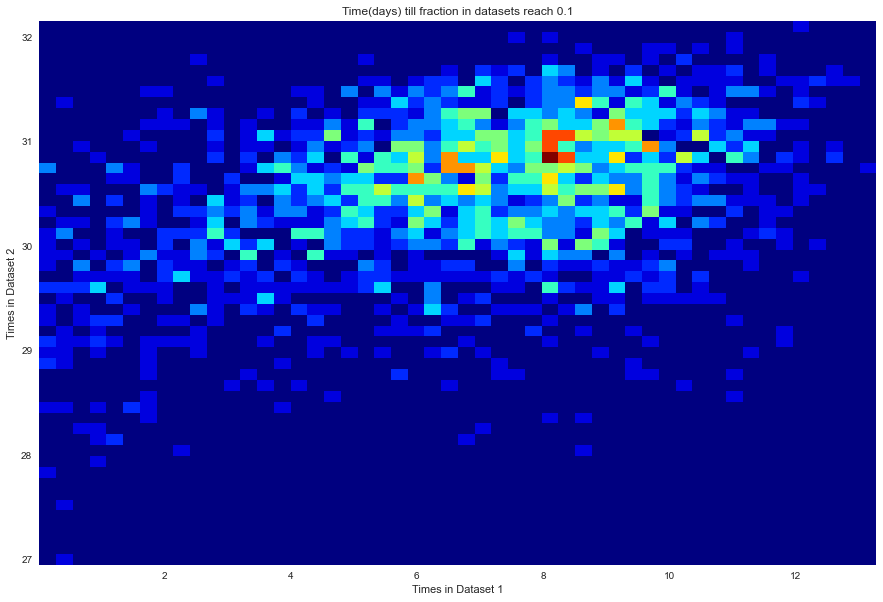

In [221]:
joint_times_distribution(dataset, filters, 0.1, bins = 50)

10it [00:02,  3.68it/s]
10it [00:02,  3.86it/s]
10it [00:02,  3.85it/s]
10it [00:02,  3.79it/s]
10it [00:02,  3.80it/s]


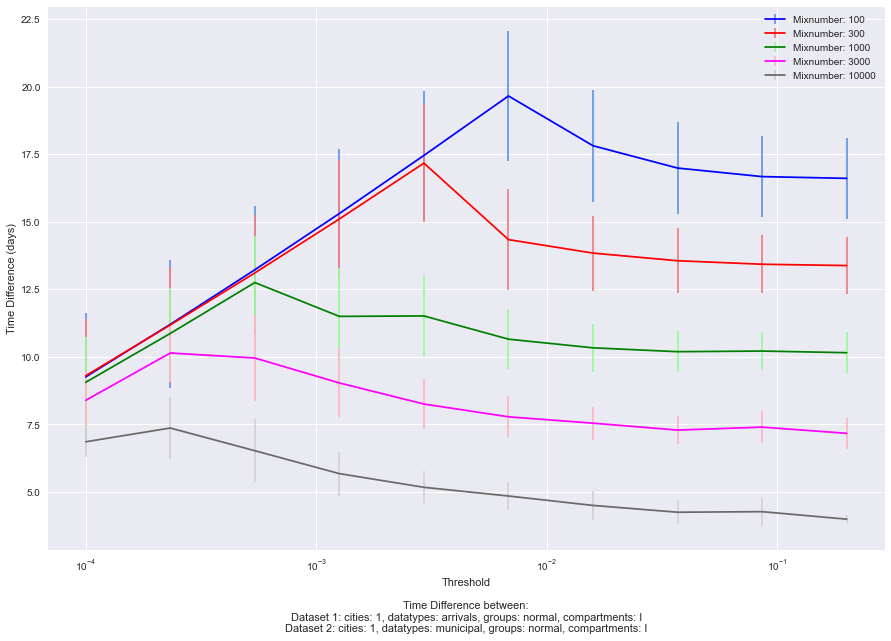

In [273]:
plot_differences(list(datasets.values()), filters, thresholds = 10**np.linspace(-4,-0.7,10), legend_labels=list(datasets.keys()))


20it [00:05,  3.82it/s]
20it [00:05,  3.89it/s]
20it [00:05,  3.80it/s]
20it [00:05,  3.83it/s]
20it [00:05,  3.84it/s]


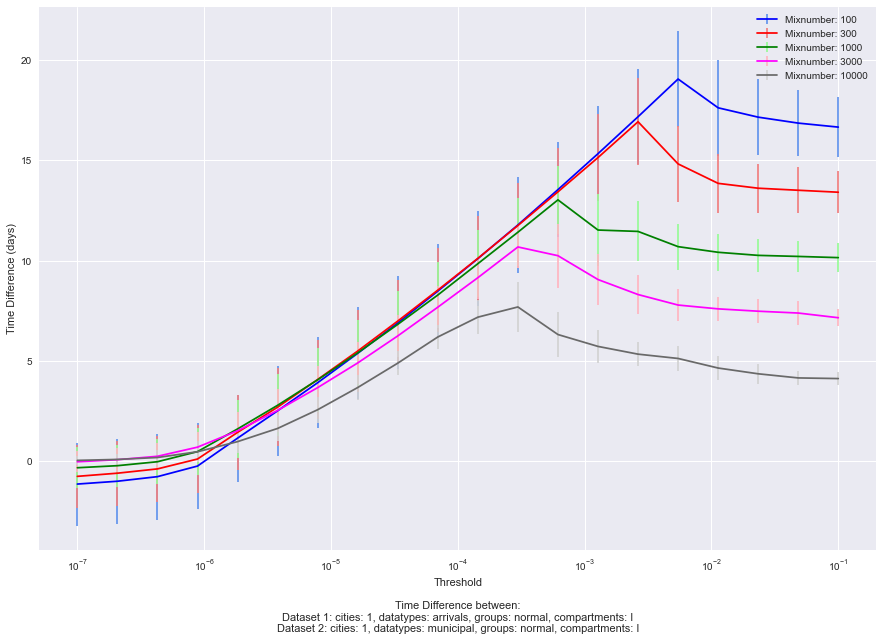

In [268]:
plot_differences(list(datasets.values()), filters, thresholds = 10**np.linspace(-7,-1,20),legend_labels=list(datasets.keys()))

In [272]:
str(range(3))

'range(0, 3)'

1/5
2/5
3/5
4/5
5/5


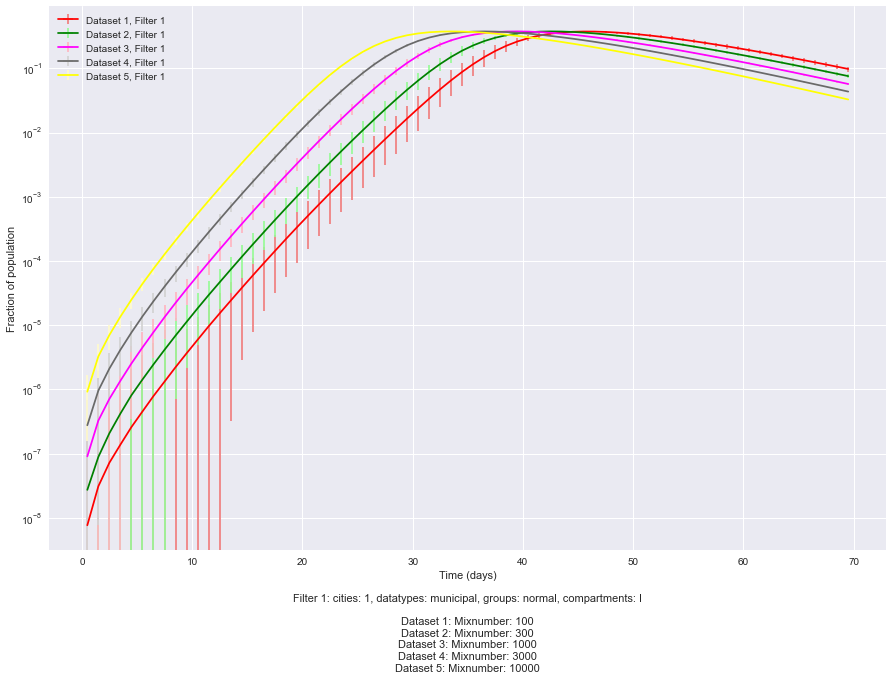

In [305]:
plot_avg_vals(datasets,[filters[1]], log = 'y', error_bars='std')

In [162]:
cities = [1]
datatypes = ['arrivals', 'municipal']
groups = basics_measles.cities[0].groups
compartments = ['I']


filters = [
    create_filter(cities = cities, datatypes = [datatype], groups = [group], compartments = compartments) for datatype in datatypes for group in groups
]
# for i, filter in filters:
#     print(filter)
# hists_at_time(data, 90, filters[3:4], density=False, bins = 50)

In [200]:
datalist.keys()

dict_keys(['Mixnumber: 100', 'Mixnumber: 300', 'Mixnumber: 1000', 'Mixnumber: 3000', 'Mixnumber: 10000'])

Dataset 1: {'cities': [1], 'datatypes': ['arrivals'], 'groups': ['normal'], 'compartments': ['I']}
Dataset 2: {'cities': [1], 'datatypes': ['municipal'], 'groups': ['normal'], 'compartments': ['I']}


/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_50788/64142062.py:271: RuntimeWarning: invalid value encountered in divide
  fractions = [a/b for a,b in zip(filtered,totals)]


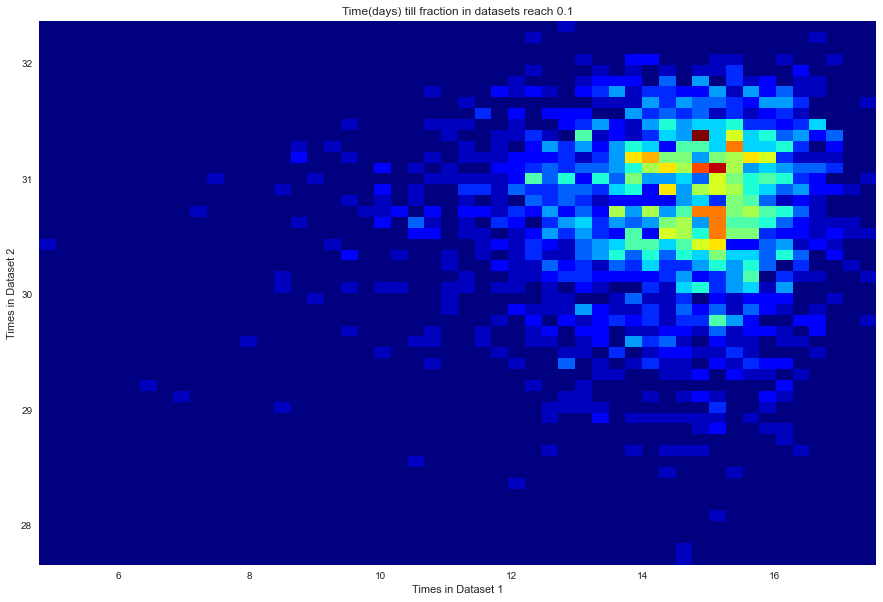

In [152]:
joint_times_distribution(basics_measles_data, filters,0.1, bins = 50)

/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_50788/64142062.py:305: RuntimeWarning: invalid value encountered in divide
  fractions = [a/b for a,b in zip(filtered,totals)]


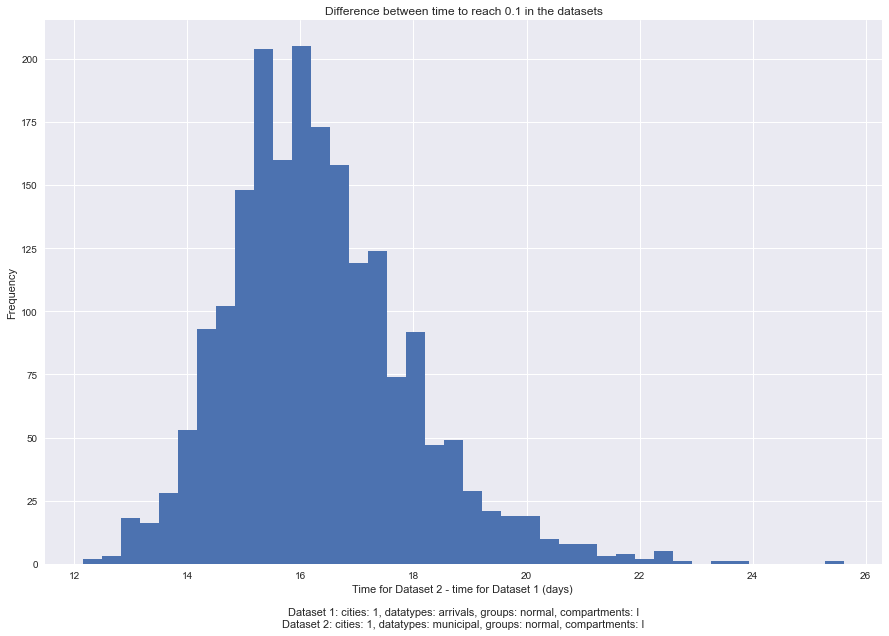

In [153]:
time_diff_at_threshold_hist(basics_measles_data,filters, 0.1, bins = 40, daily= False)


In [163]:
basics_daily = basics_measles_data.daily_avg()

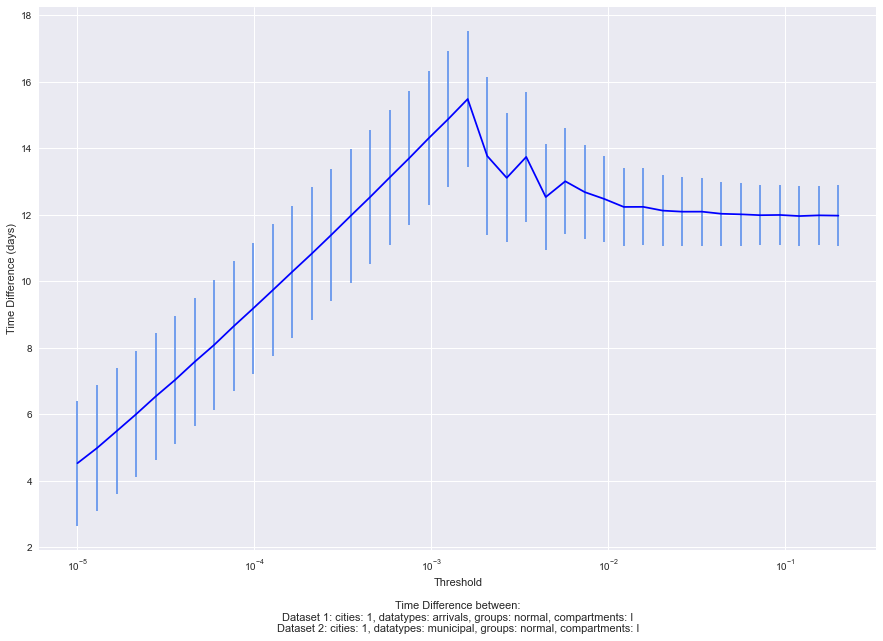

In [191]:
plot_differences([basics_daily], filters)

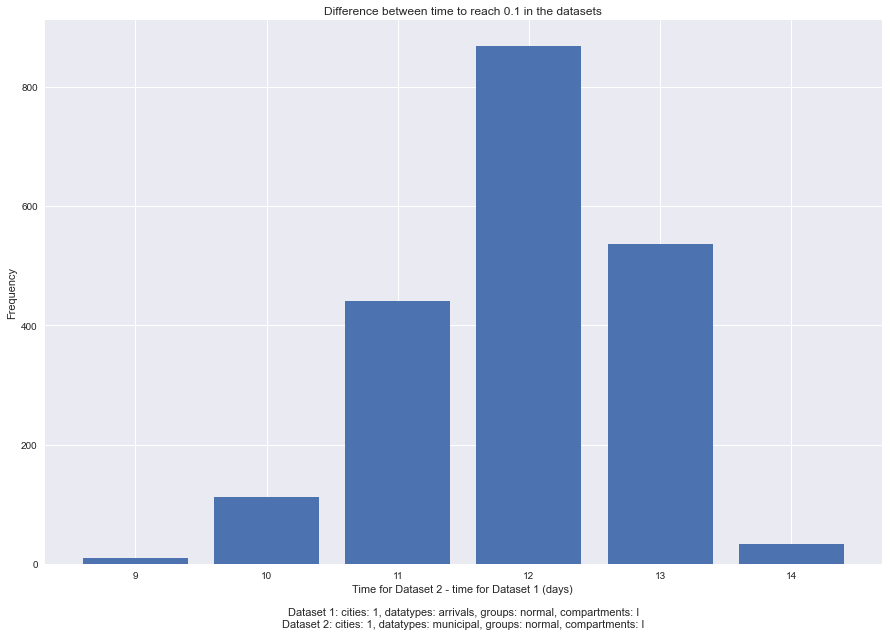

In [167]:
time_diff_at_threshold_hist(basics_daily,filters, 0.1, bins = 20, daily= True, density=False)


Dataset 1: {'cities': [1], 'datatypes': ['arrivals'], 'groups': ['normal'], 'compartments': ['I']}
Dataset 2: {'cities': [1], 'datatypes': ['municipal'], 'groups': ['normal'], 'compartments': ['I']}


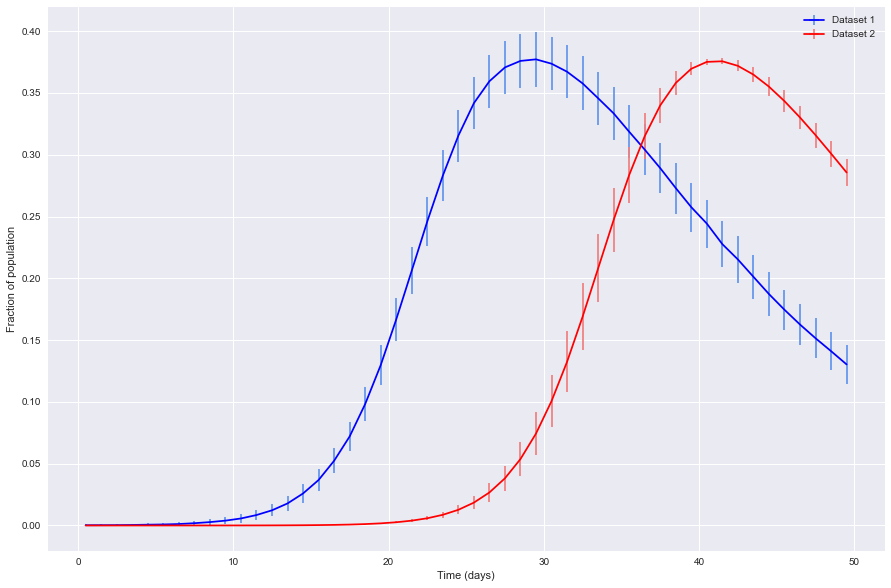

In [168]:
plot_avg_vals(basics_daily, filters)

In [958]:
basics_measles_data = SimData(basics_measles_data.array, basics_measles_data.all_labels, basics_measles_data.axis_order)

Dataset 1: {'cities': [1], 'datatypes': ['arrivals'], 'groups': ['normal'], 'compartments': ['I']}
Dataset 2: {'cities': [1], 'datatypes': ['municipal'], 'groups': ['normal'], 'compartments': ['I']}


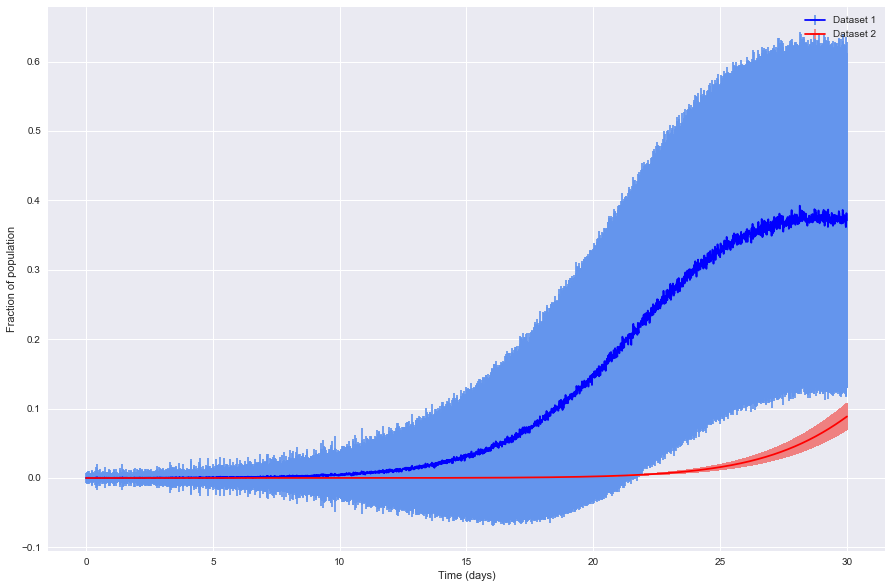

In [157]:
plot_avg_vals(basics_measles_data,filters)

Dataset 1: {'cities': [1], 'datatypes': ['arrivals'], 'groups': ['frequent_fliers'], 'compartments': ['E', 'I'], 'times': [89.99499749874937]}


/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_24805/1045008343.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


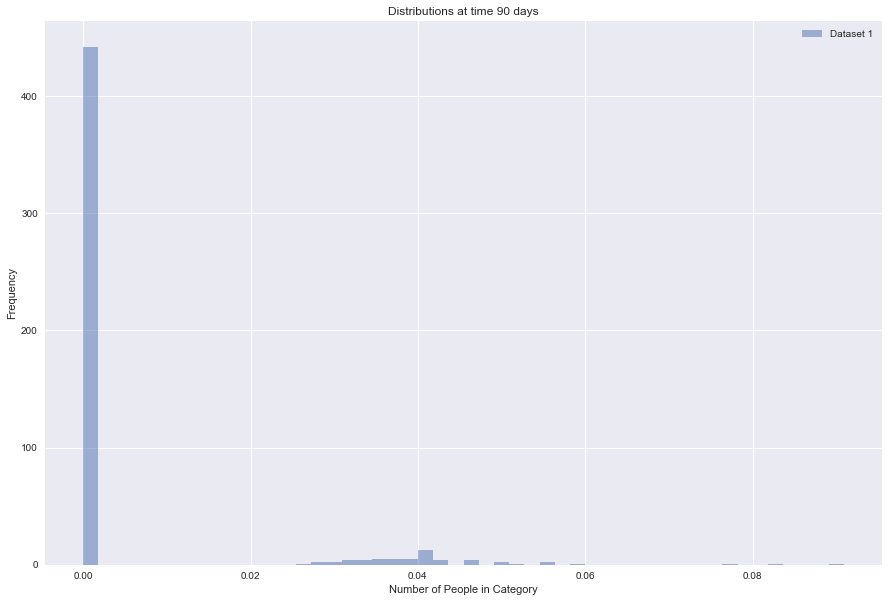

In [823]:
hists_at_time(basics_measles_data, 90, filters[3:], density=False, bins = 50)


/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_75546/47904964.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


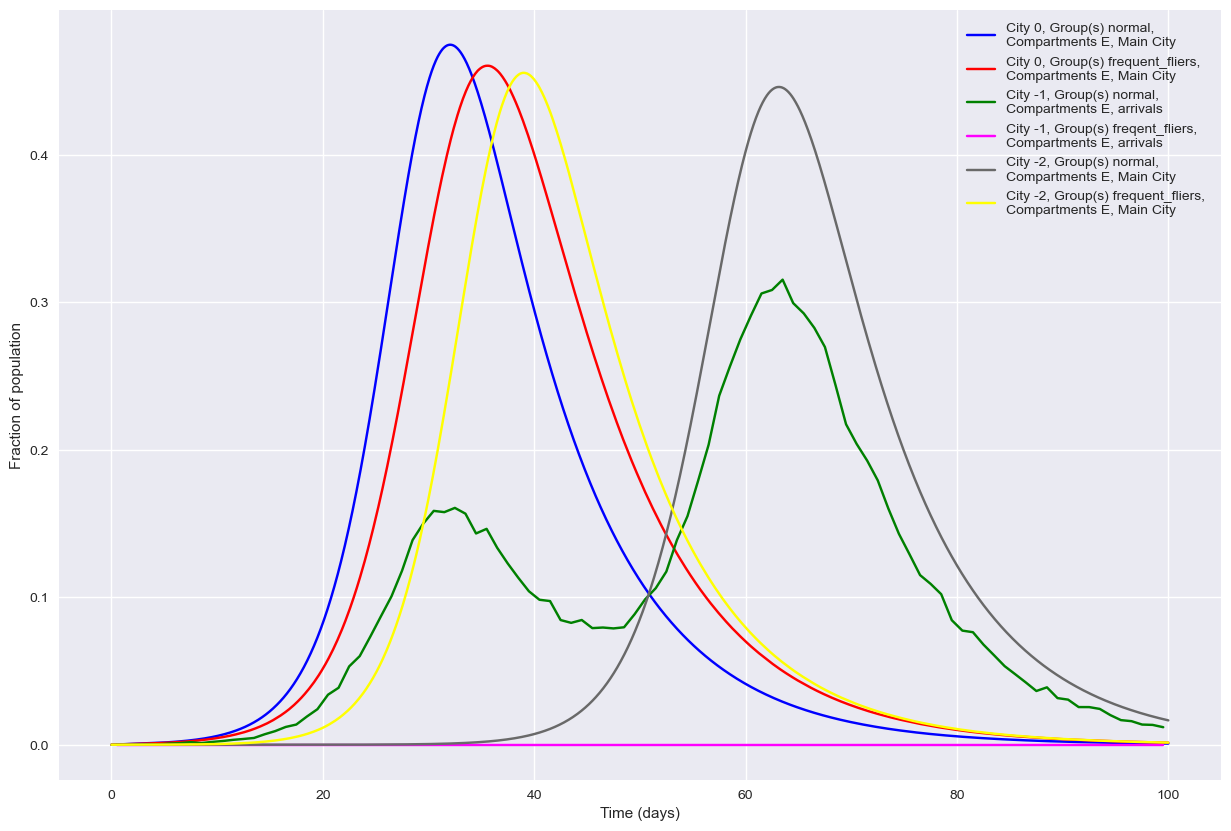

In [2175]:
ffs_measles.plot_avg_vals(which_cities = [0,0,-1,-1, -2,-2], data_types = ['municipal','municipal','arrivals','arrivals', 'municipal','municipal'], included_compartments = 'E',included_groups = [['normal'],['frequent_fliers'], ['normal'],['frequent_fliers'], ['normal'],['frequent_fliers']], error_bars='None', log = '')

/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_75546/47904964.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


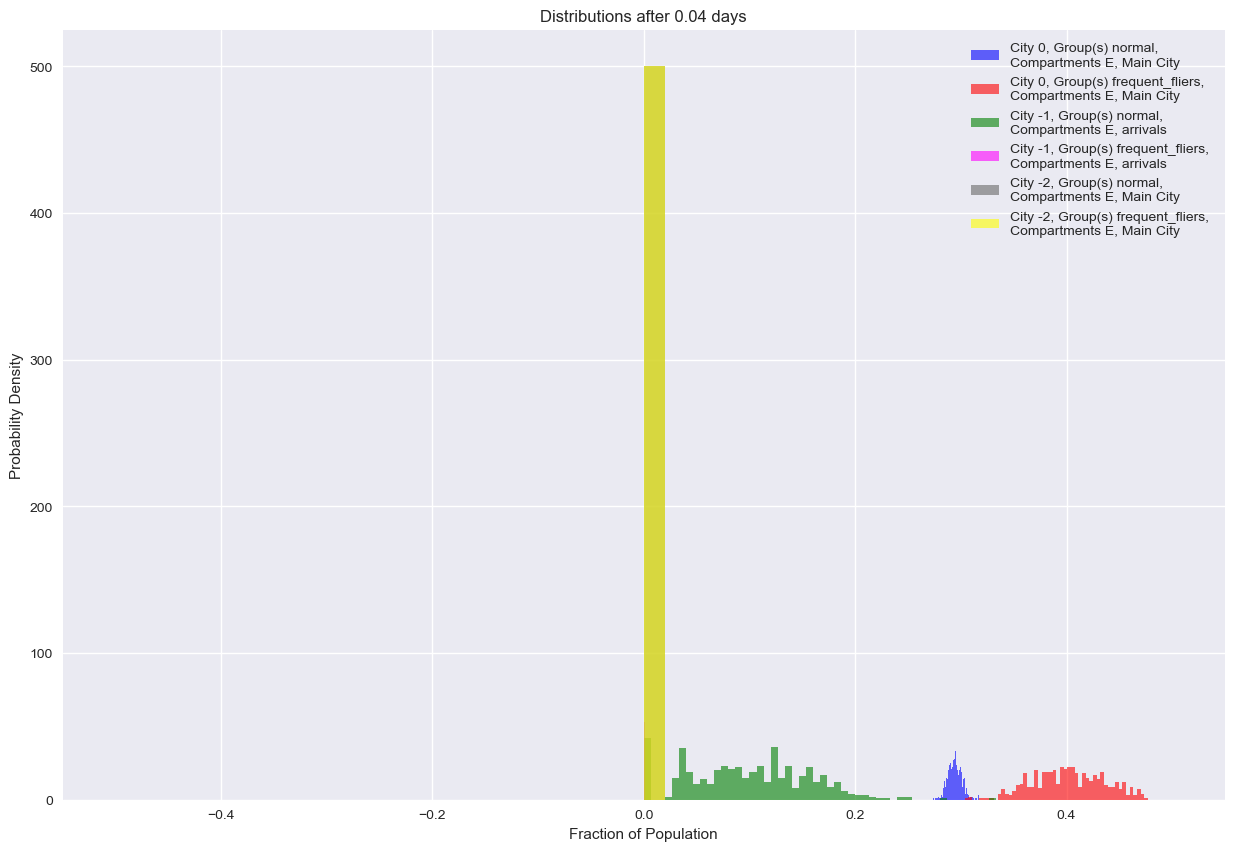

In [2154]:
ffs_measles.hists_at_time(times = np.array([40]), which_cities = [0,0,-1,-1, -2,-2], data_types = ['municipal','municipal','arrivals','arrivals', 'municipal','municipal'], included_compartments = 'E',included_groups = [['normal'],['frequent_fliers'],['normal'],['frequent_fliers'], ['normal'], ['frequent_fliers']], log = '', density=False)

/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_75546/47904964.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


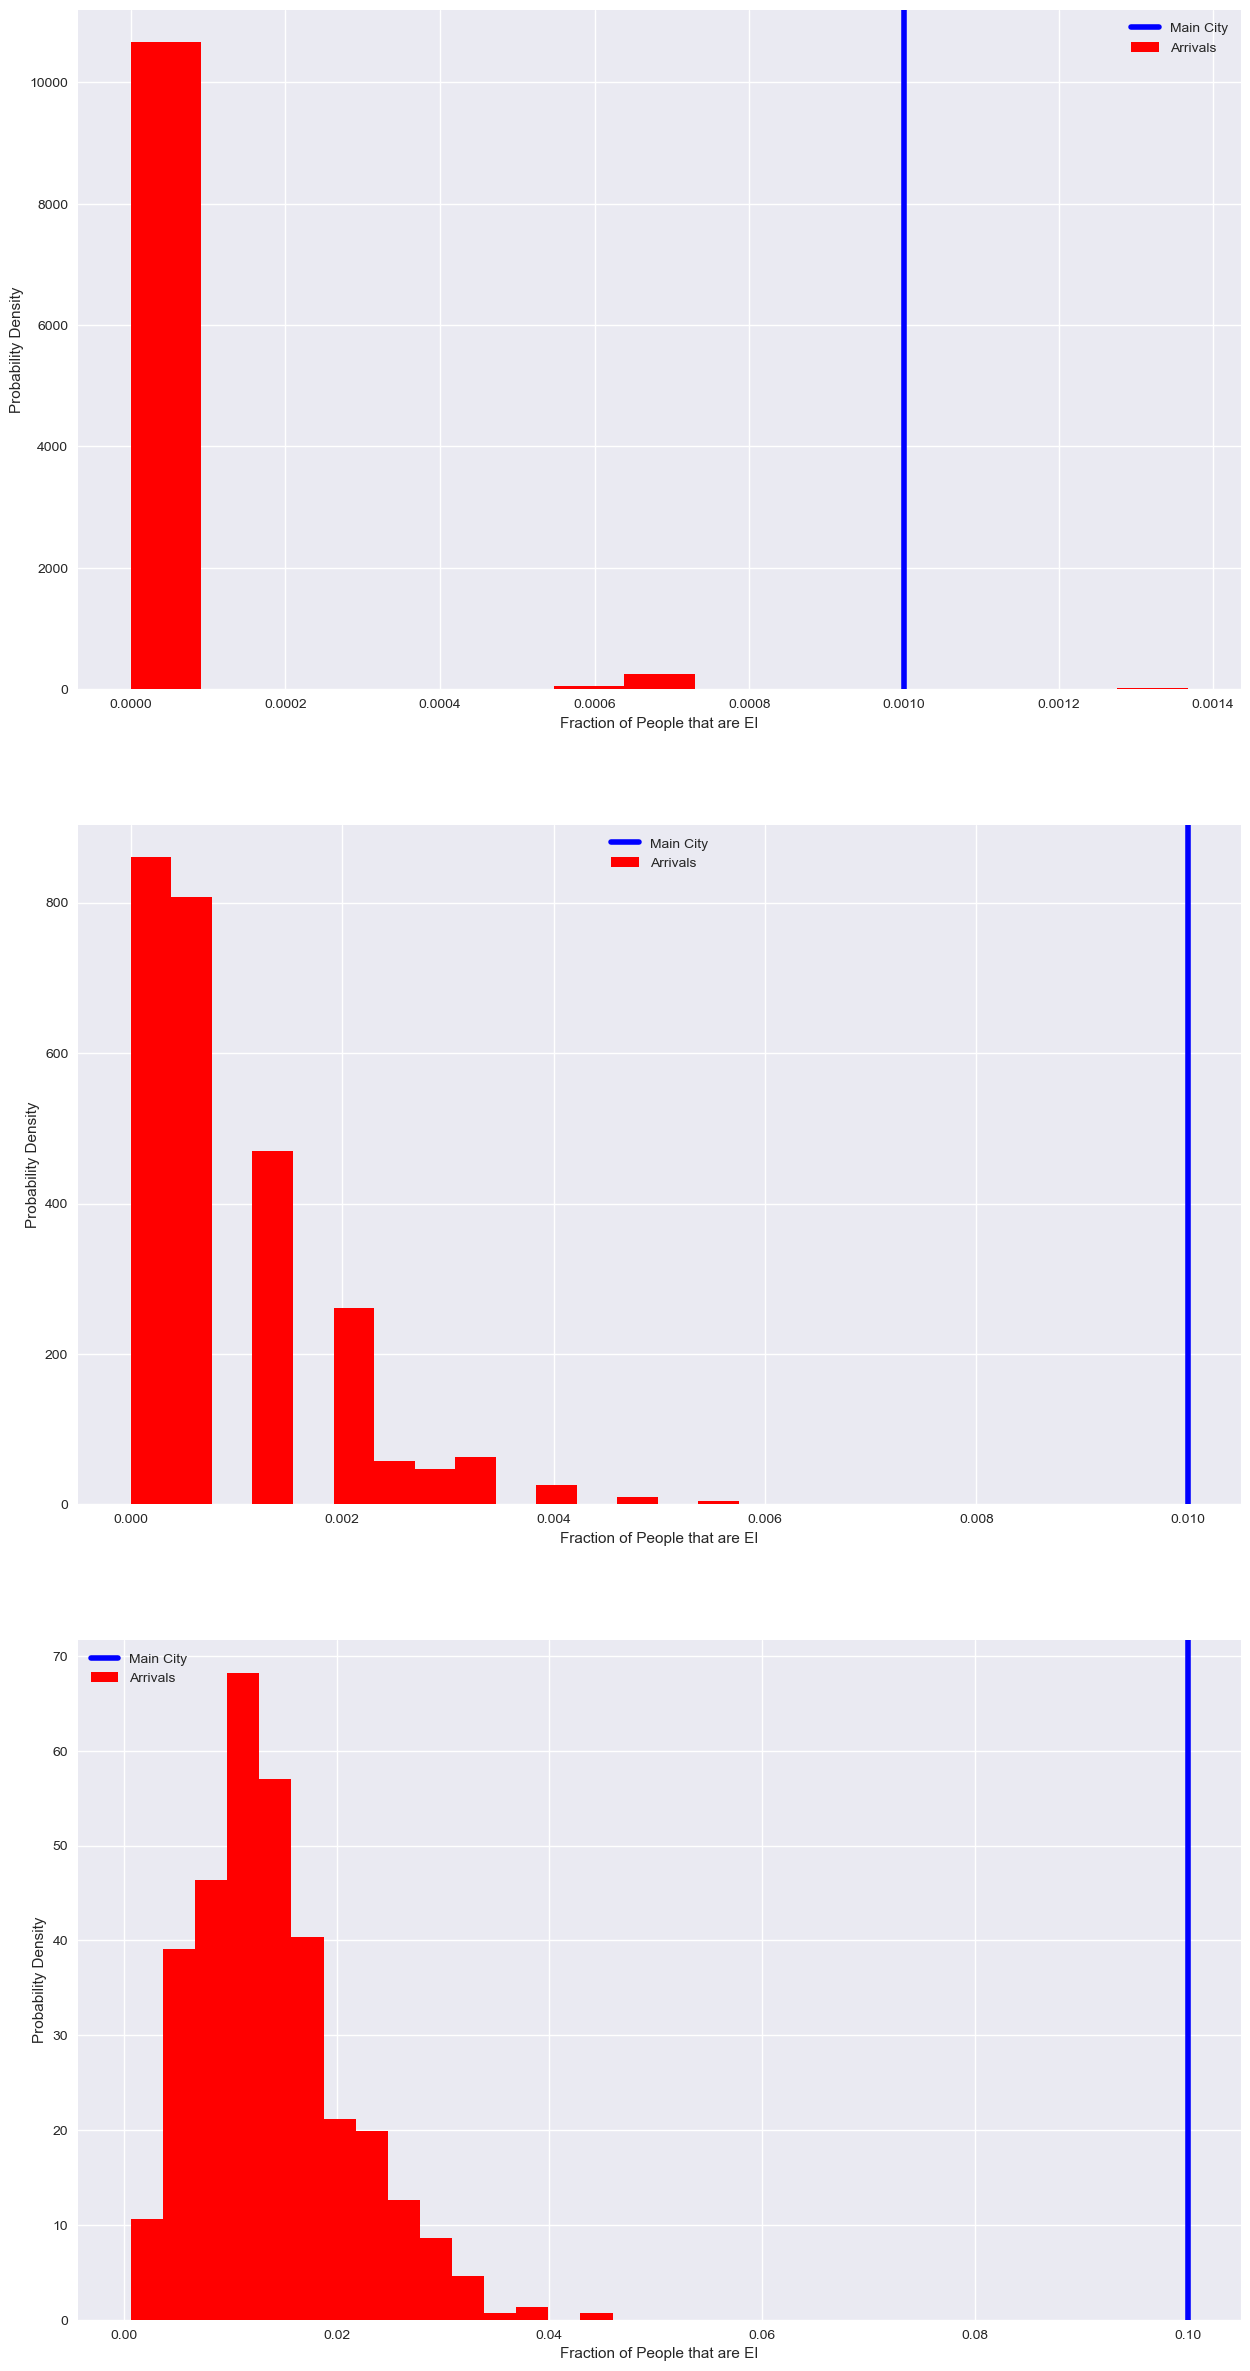

In [2155]:
ffs_measles.cities[0].hist_arrivals_at_municipal_threshold()

/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_75546/47904964.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


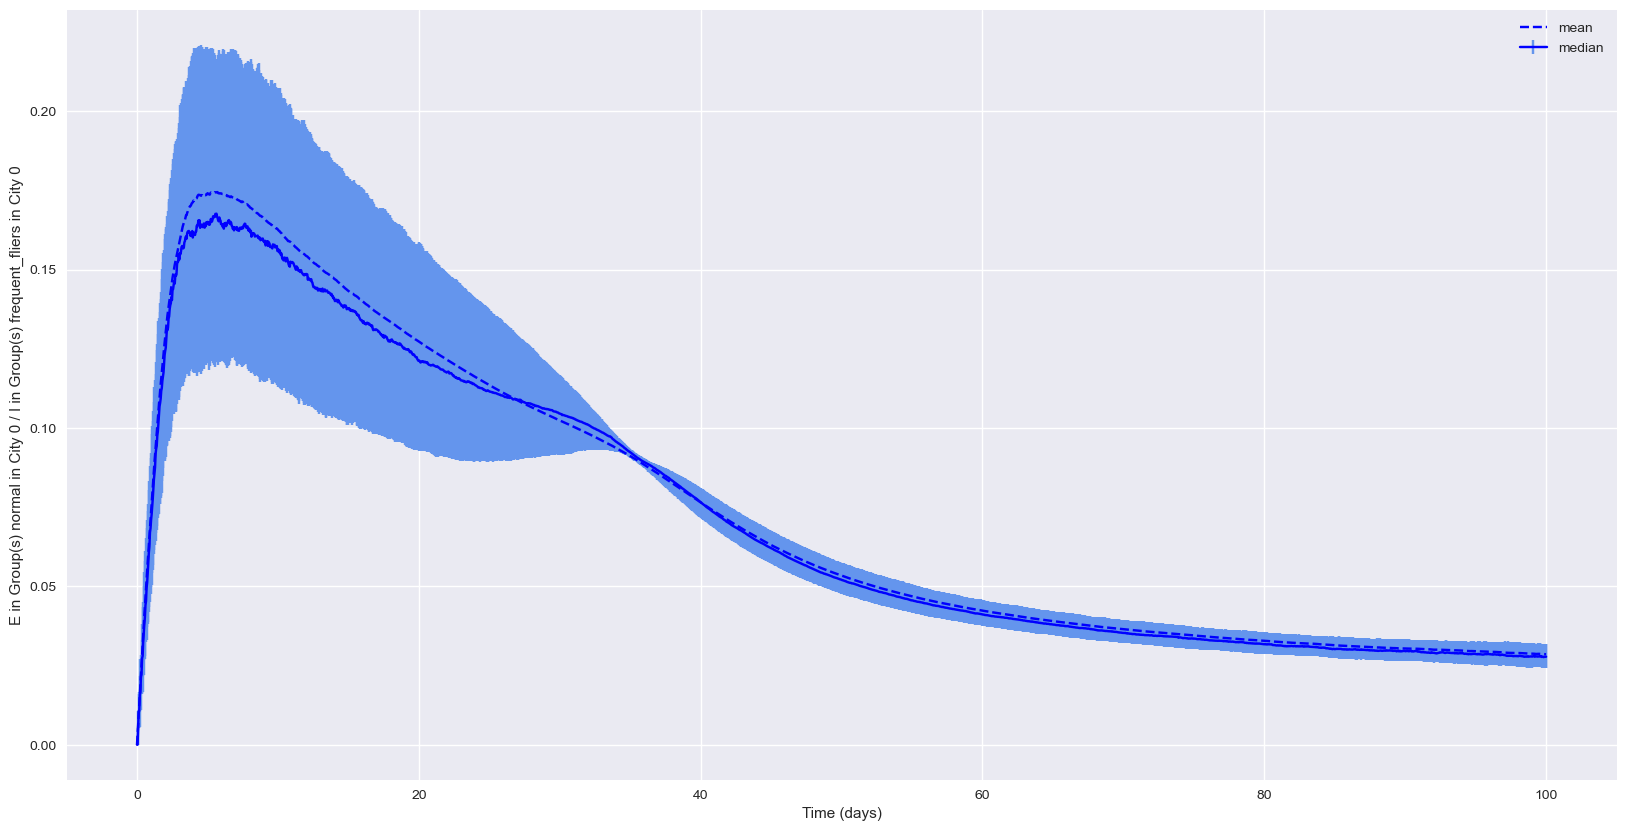

In [2167]:
ffs_measles.plot_infection_ratio(0,0,'times','I','E',['normal'],['frequent_fliers'],log='', error_bars='IQR')

/var/folders/b1/fnk7c7p930db07fwwdt_jjr00000gn/T/ipykernel_75546/47904964.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


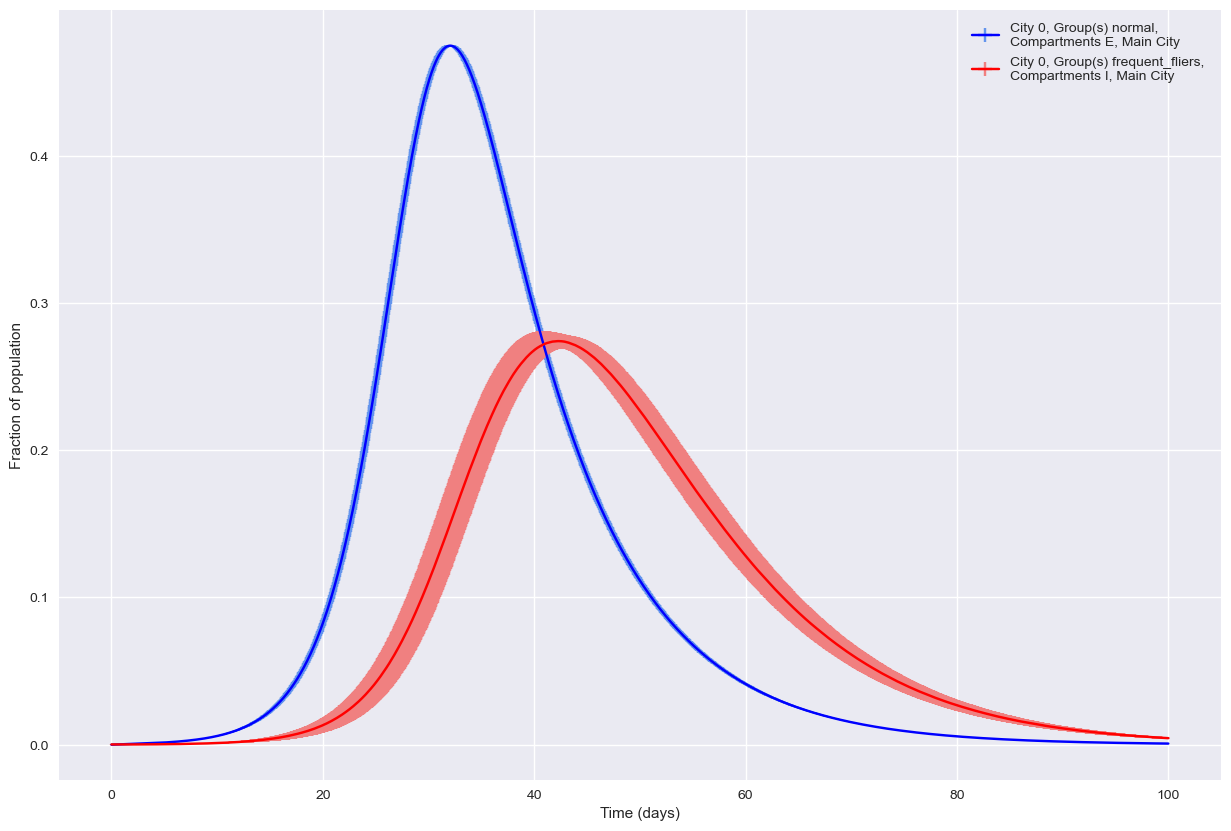

In [2166]:
ffs_measles.plot_avg_vals(which_cities = [0,0], data_types = ['municipal','municipal'], included_compartments = ['E','I'],included_groups = [['normal'],['frequent_fliers']], error_bars='std', log = '')